In [92]:
import numpy as np
import mne 
import scipy 
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import cv2

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [2]:

def conf_matrix_plot(categs, matrix_bef, size=3,perc_flg=True):
    
    group_percentages = ["{0:.2%}".format(value) for value in
                     matrix_bef.flatten()/np.sum(matrix_bef)]
    
    if perc_flg:
        labels = np.asarray(group_percentages).reshape(size,size)
    else:
        labels =matrix_bef
    sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
    matplotlib.rcParams.update({'font.size': 32})
    fig1, ax1 = plt.subplots(figsize=[10,8])
    sns.heatmap(matrix_bef,cmap='Blues',xticklabels=categs,yticklabels=categs,annot=labels, fmt='',ax=ax1)
    
    
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [3]:
sec=5
video_path='../../../mp.mp4'

In [4]:
def get_frame(video_path, sec):
    
    calc_timestamps = [0.0]
    cap = cv2.VideoCapture( video_path)
    timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
    fps = cap.get(cv2.CAP_PROP_FPS)

    while(cap.isOpened()):
        frame_exists, curr_frame = cap.read()
        #print(np.sum(curr_frame))
        #print('lol')
        if frame_exists:
            timestamps = cap.get(cv2.CAP_PROP_POS_MSEC)
            calc_timestamps.append(calc_timestamps[-1] + 1000/fps)
            ts=calc_timestamps[-1] + 1000/fps
            
            if sec<(ts/1000):
                print(ts/1000)
                #print('ghl;', np.sum(curr_frame))
                plt.figure()
                plt.imshow(curr_frame)
                break

In [5]:
#fps = vcap.get(cv2.CV_CAP_PROP_FPS)

def get_frmae(video_path, second):
    '''function probably is incorrect but it seemed to wors as get_frame'''
    
    #start=20
    
    vcap = cv2.VideoCapture( video_path)
    ret, frame = vcap.read()
    #fps = vcap.get(cv2.CAP_PROP_FPS)
    #times 1/24
    
    frame_num=int(second*24)

    for i in range(frame_num):
        #vcap = cv2.VideoCapture('../../../ks.mp4')
        ret, frame = vcap.read()
    #plt.close()
    print(second)
    print(i)
    plt.figure()
    plt.imshow(frame)



In [6]:
#get data
raw_data=mne.io.read_raw_brainvision('../../mp/NeoRec_2022-12-07_14-10-26.vhdr', preload=True)

Extracting parameters from ../../mp/NeoRec_2022-12-07_14-10-26.vhdr...
Setting channel info structure...
Reading 0 ... 1351953  =      0.000 ...   675.976 secs...


In [7]:
#get epochs
events,ids=mne.events_from_annotations(raw_data)

Used Annotations descriptions: ['1/Event', 'New Segment/']


In [8]:
#crop fron the moment backspace key was pressed
raw_data.crop(events[-1,0]/raw_data.info['sfreq'], None)

<RawBrainVision | NeoRec_2022-12-07_14-10-26.eeg, 15 x 1325087 (662.5 s), ~151.7 MB, data loaded>

In [9]:
raw_data.ch_names

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'x', 'y', 'z']

In [10]:
#Extract only accelerometry data
raw_data_acc=raw_data.copy().drop_channels(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

Using matplotlib as 2D backend.


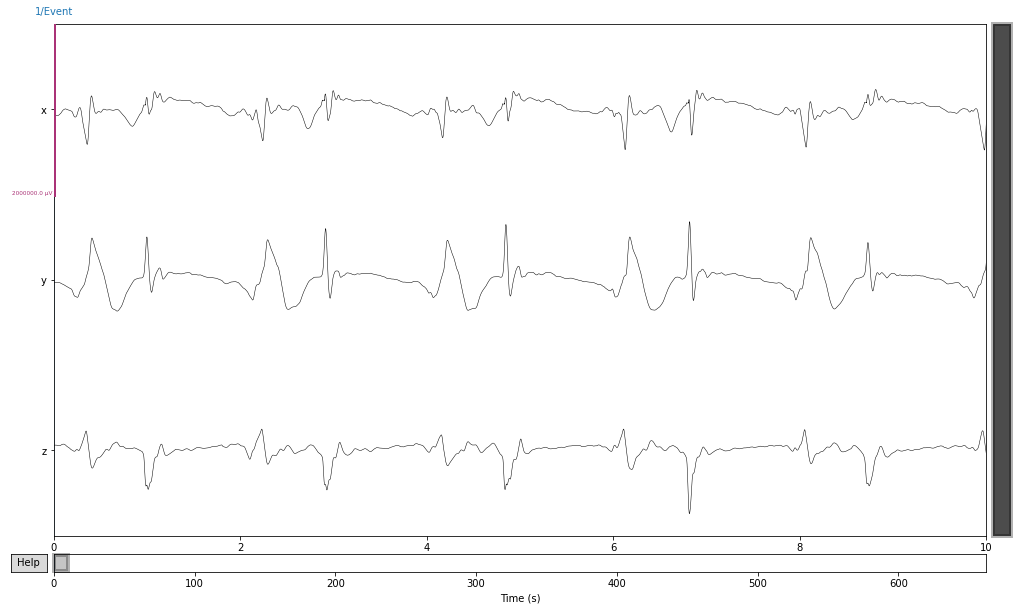

In [11]:
raw_data_acc.plot(scalings={'eeg':0.1e1})
plt.show()

In [12]:
#taking the matrix of accelerometry data
xyz=raw_data_acc.get_data()


In [13]:
#we working with y axes because it is the has a clear pattern
y_data=xyz[1,:]

In [14]:
#a raw estimate of the steppinng cycle with 
start=0
period=3800
end=start+period


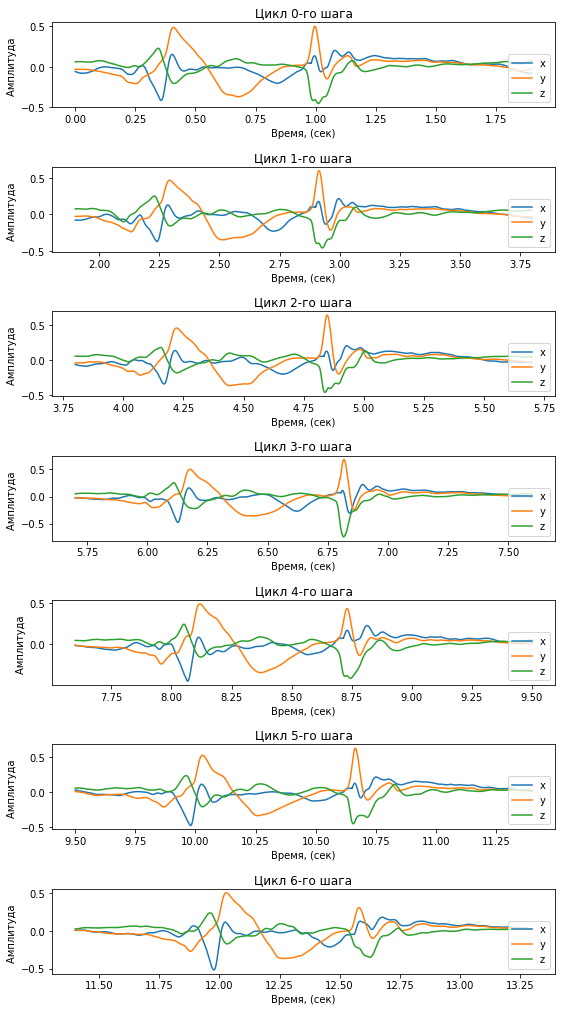

In [15]:
'''
plot several cycles to check how acc data looks like
'''

plt.close()

cycles=7

fig,ax=plt.subplots(cycles,1, figsize=(9,2.5*cycles))
plt.subplots_adjust(hspace=0.7)

for i in range(cycles):
    ax[i].plot( np.arange(start+period*i,end+period*i)/raw_data.info['sfreq'],  xyz[:,start+period*i:end+period*i].T  , label=['x', 'y', 'z'])
    ax[i].set_title('Цикл '+str(i)+'-го шага')
    ax[i].set_xlabel('Время, (сек)')
    ax[i].set_ylabel('Амплитуда ')
    ax[i].legend(loc='lower right')


In [16]:
def find_peaks(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_>max_)[0]
    
    if max_flg:
        return inds, max_
    
    else:
        return inds
    
    
def find_peaks_min(array_, koef=1.1, max_flg=False):

    mean_=np.mean(array_)
    std_=np.std(array_)

    max_=mean_+koef*std_
    min_=mean_-koef*std_

    max_array_=[max_]*len(array_)
    min_array_=[min_]*len(array_)

    inds=np.where(array_<min_)[0]
    
    if max_flg:
        return inds, min_
    
    else:
        return inds
    
def reduce_peaks(marks_array_inds,  threhold, with_log=False,):
    
    new_marks_array_inds=[marks_array_inds[0]]
    for i in range(1,len(marks_array_inds)):
        if marks_array_inds[i]-new_marks_array_inds[-1]<threhold:
            if with_log:
                print(i)
        else:
            new_marks_array_inds.append(marks_array_inds[i])

    return new_marks_array_inds


In [17]:
#extracting peak of y accelerometry 
inds=find_peaks(y_data,1.7)

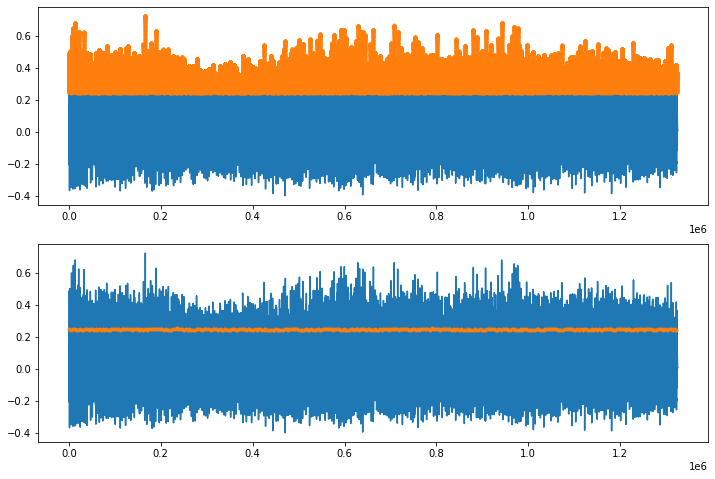

In [18]:
plt.close()
fig,ax=plt.subplots(2,1, figsize=(12,8))
ax[0].plot(y_data)
ax[0].plot(inds,y_data[inds], '.')


new_peaks=reduce_peaks(inds, 2000) #reducing its number
ax[1].plot(y_data)
ax[1].plot(new_peaks,y_data[new_peaks], '.')

In [97]:
#mannually adjust the moments of the support phase
events_max=np.array(new_peaks)+raw_data.first_samp+1200

In [98]:

zeros=[0]*len(events_max)
marks=[1]*len(events_max)
ones=np.vstack([events_max,zeros,marks]).T


zeros=[0]*len(events_max)
marks=[2]*len(events_max)
twos=events_max+800 #mannually adjusted duration in timme stamps
twos=np.vstack([twos,zeros,marks]).T


In [99]:
len(ones)
len(twos)

346

In [100]:
events=np.vstack([ones,twos])
events=events[events[:, 0].argsort()]
events[:,0]=events[:,0]

In [101]:
raw_data.first_samp

26867

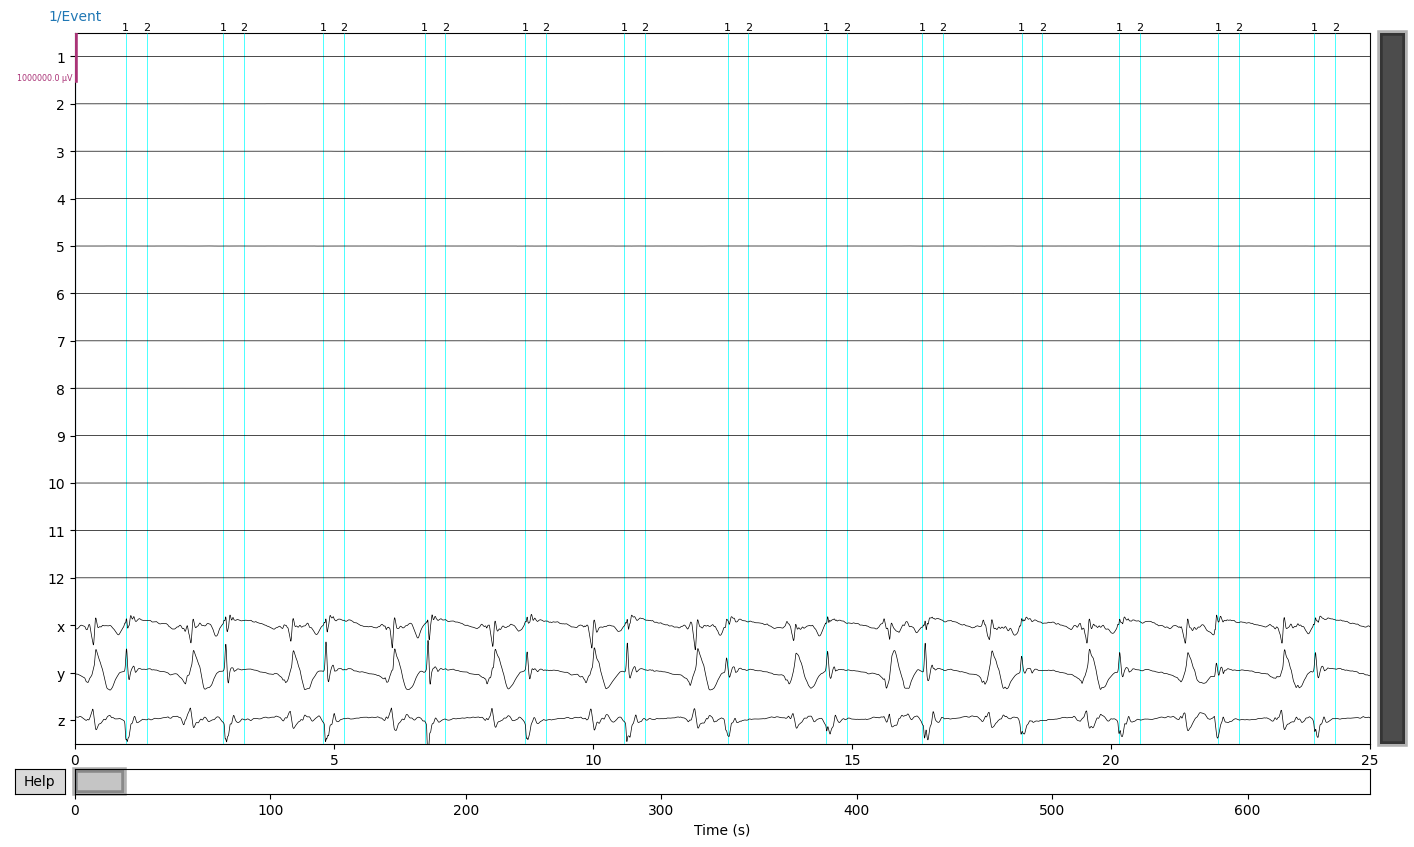

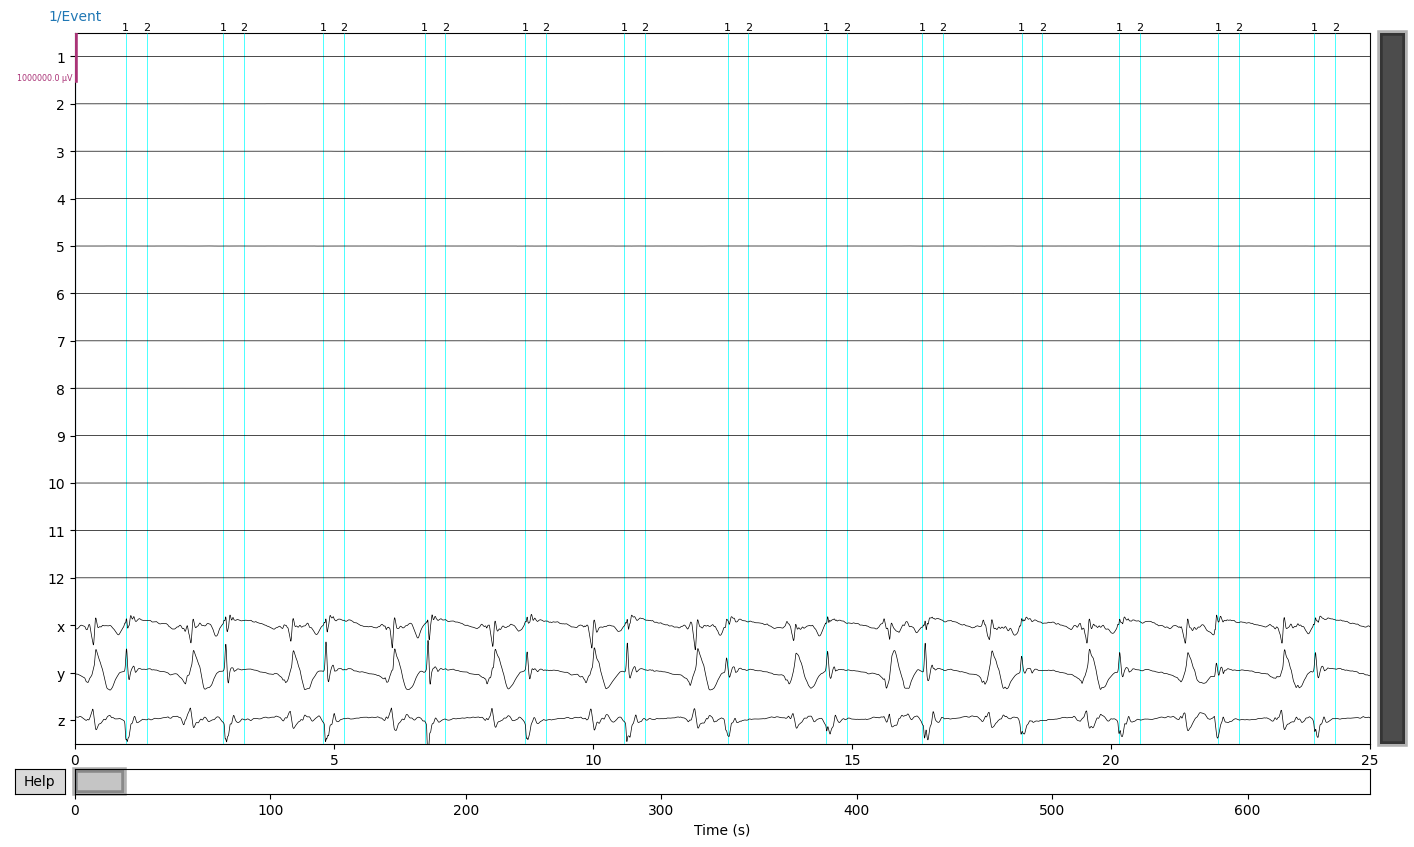

In [102]:
raw_data.plot(events,scalings={'eeg':5e-1}, duration=25)

14.501
14.514500000000043
14.901
14.914900000000044


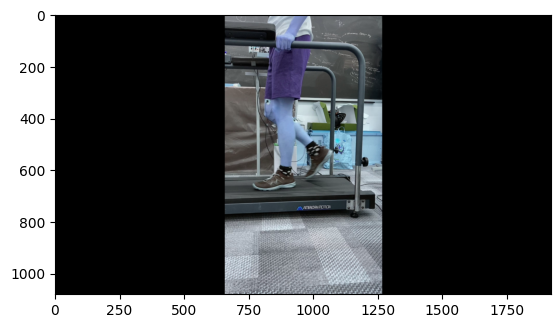

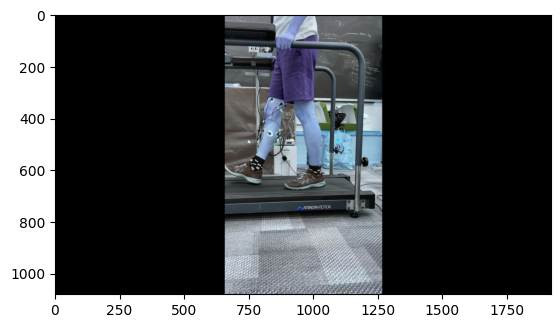

In [104]:
ind=7

s=( (ones[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)

s=( (twos[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)

In [48]:
raw_data_emg=raw_data.copy().drop_channels(['x','y','z'])


SAMPLING_FREQUENCY = raw_data_emg.info['sfreq']
CHANNEL_NUMBER = len(raw_data_emg.ch_names)
BANDPASS_LIMITS = (200, 500)

In [49]:
def get_features_labels(epochs):
    epochs.filter(200, 900).apply_hilbert(envelope=True).filter(0, 20)
    epochs_data=epochs._data
    epo_=epochs_data.reshape(epochs_data.shape[0],epochs_data.shape[1]*epochs_data.shape[2])

    X = epo_
    y = epochs.events[:,-1].flatten()
    return X, y


In [50]:
def cross_val_calssifier(X, y, classifier, categs=['Фаза-1','Фаза-2']):

    tscv=TimeSeriesSplit(max_train_size=None, n_splits=4)

    ac_list=[]

    for train_index, test_index in tscv.split(X):
        print()
        #print("TRAIN:", train_index, "TEST:", test_index) 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        

        pca = PCA(6)
        
        X_train = pca.fit_transform(X_train)
        classifier.fit(X_train, y_train)

        X_test=pca.transform(X_test)
        ac=classifier.score(X_test, y_test)
        
        print("TRAIN:", X_train.shape,y_train.shape )
        print("TEST:", X_test.shape, y_test.shape) 
        
        print('Accuracy:', ac)

        ac_list.append(ac)

        preds=classifier.predict(X_test)
        matrix=confusion_matrix(y_test,preds)
        
        
        print("Количество классов:", len(categs))
        conf_matrix_plot(categs, matrix,len(categs))
        conf_matrix_plot(categs, matrix ,len(categs), perc_flg=False)
    
    

In [51]:
#making the copy of initial raw to make epochs
raw_hil = raw_data_emg.copy()#.filter(BANDPASS_LIMITS[0], BANDPASS_LIMITS[1]).apply_hilbert(envelope=True).filter(0, 20)
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
692 matching events found
No baseline correction applied
0 projection items activated
Loading data for 692 events and 1001 original time points ...
0 bad epochs dropped


In [52]:
#get raw
X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)


Setting up band-pass filter from 2e+02 - 9e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 900.00 Hz
- Upper transition bandwidth: 100.00 Hz (-6 dB cutoff frequency: 950.00 Hz)
- Filter length: 133 samples (0.067 sec)

Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1321 samples (0.660 sec)



/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_23484/1321716249.py:2: RuntimeWarning: filter_length (1321) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(200, 900).apply_hilbert(envelope=True).filter(0, 20)


X:  (692, 12012)
Y:  (692,)



TRAIN: (140, 6) (140,)
TEST: (138, 6) (138,)
Accuracy: 1.0
Количество классов: 2

TRAIN: (278, 6) (278,)
TEST: (138, 6) (138,)
Accuracy: 0.9855072463768116
Количество классов: 2

TRAIN: (416, 6) (416,)
TEST: (138, 6) (138,)
Accuracy: 0.9927536231884058
Количество классов: 2

TRAIN: (554, 6) (554,)
TEST: (138, 6) (138,)
Accuracy: 1.0
Количество классов: 2


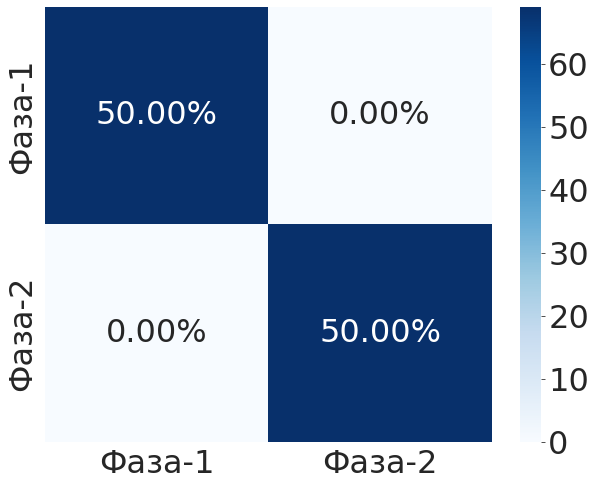

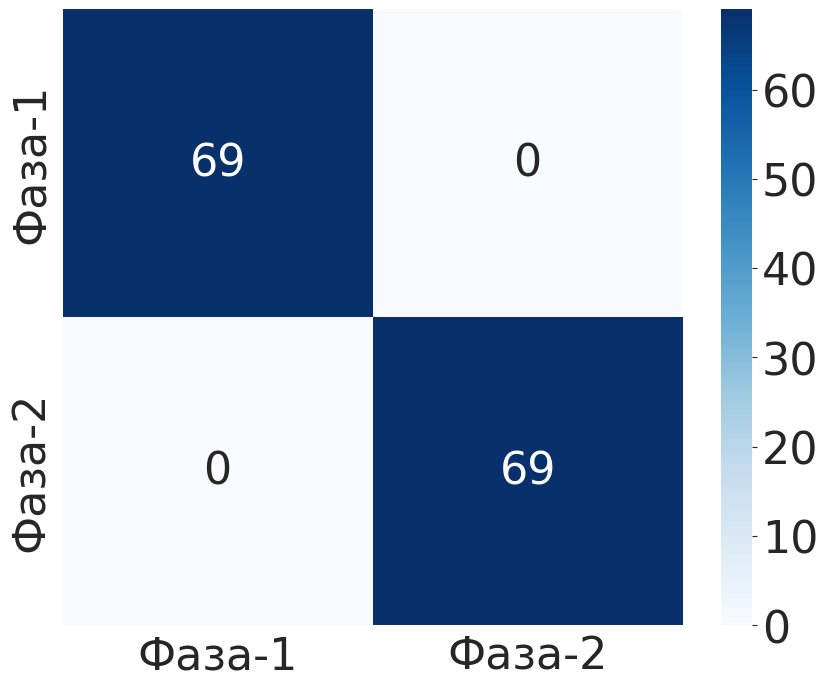

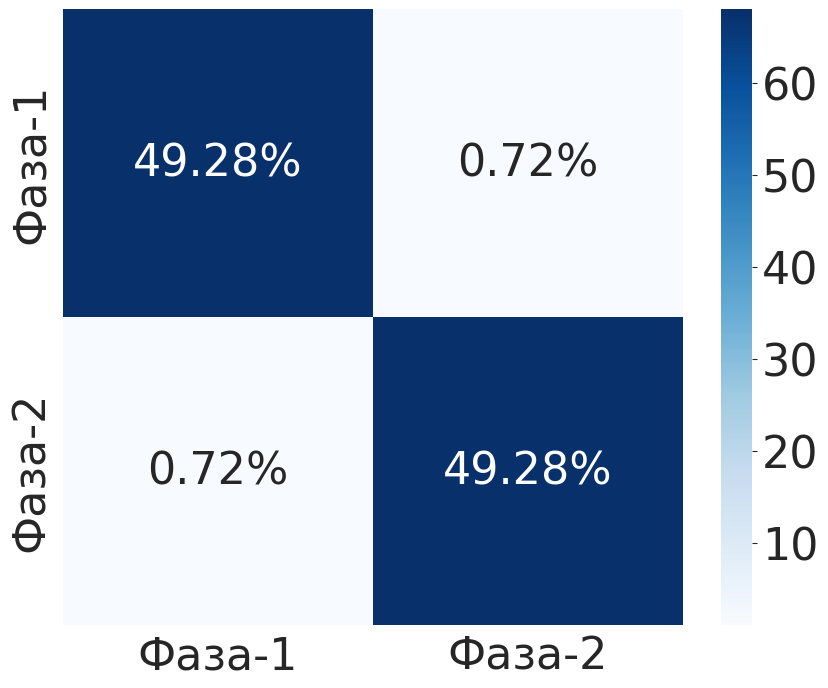

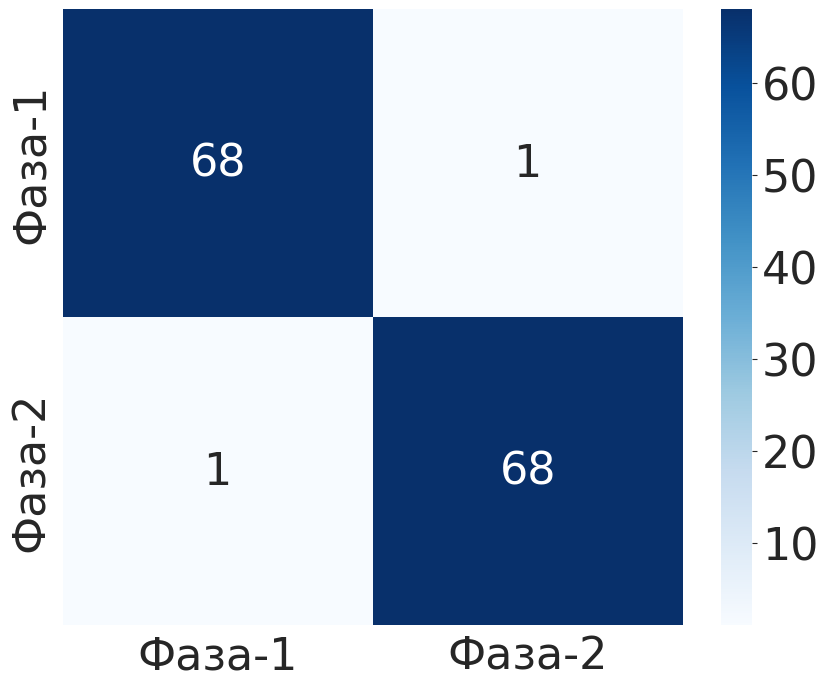

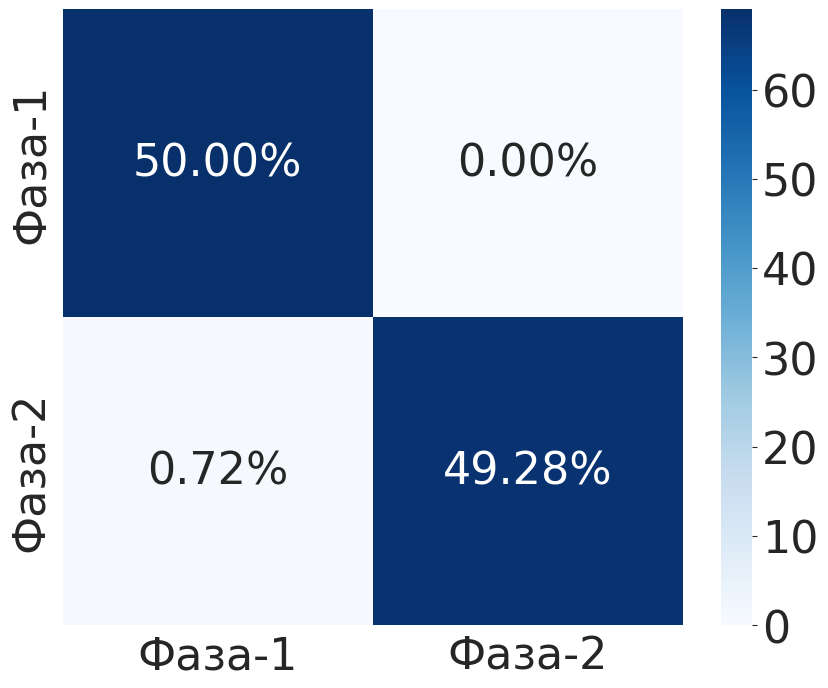

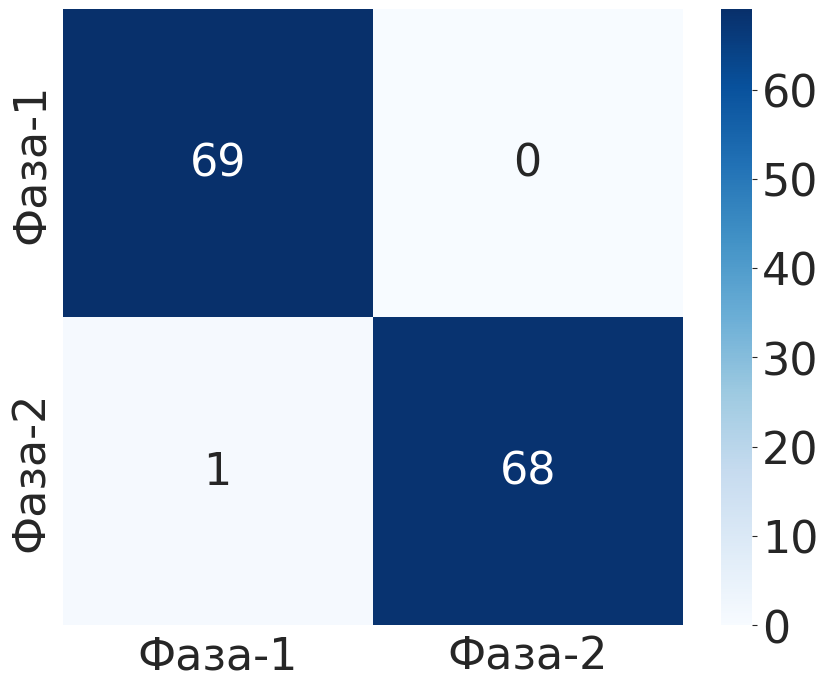

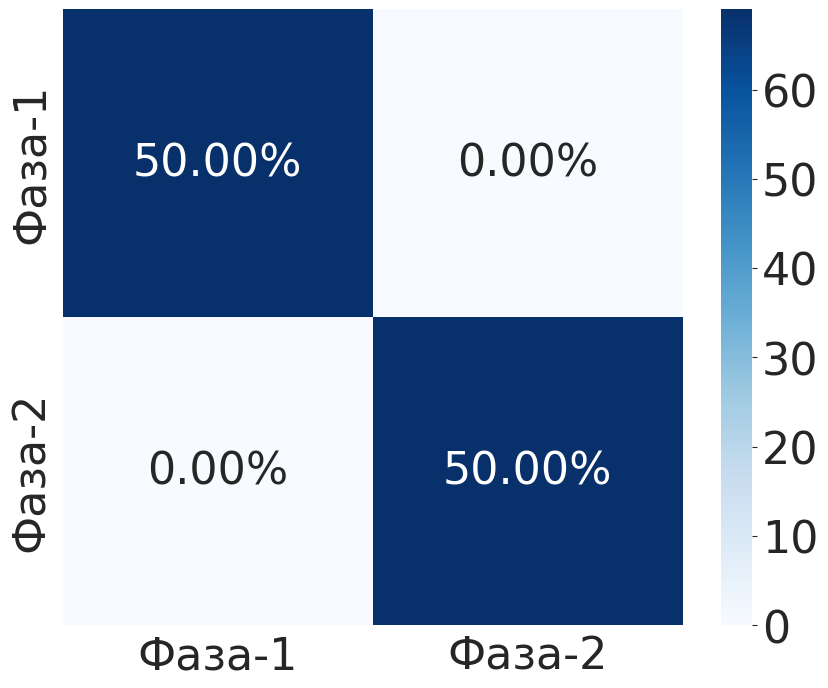

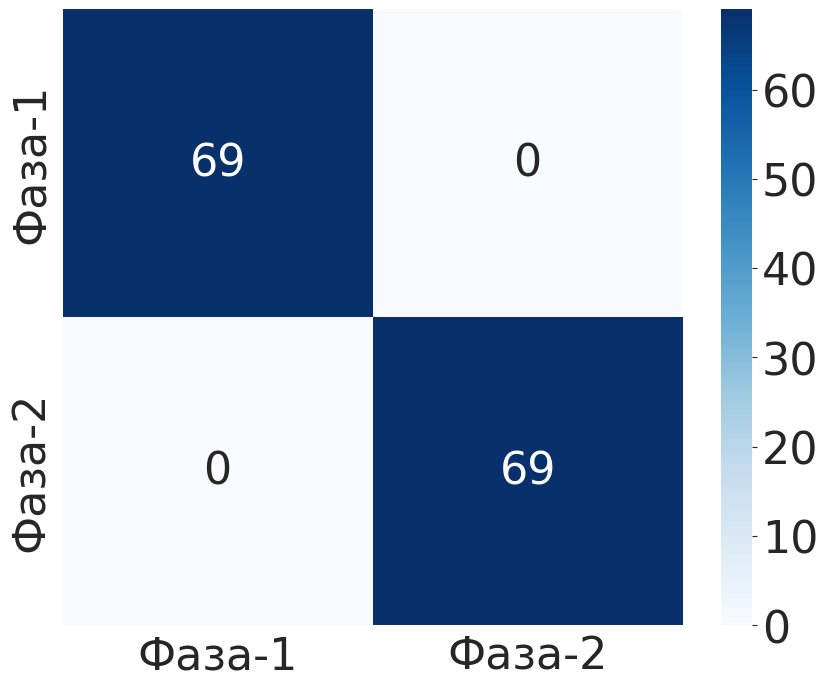

In [53]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
cross_val_calssifier(X, y , classifier)



TRAIN: (140, 6) (140,)
TEST: (138, 6) (138,)
Accuracy: 1.0
Количество классов: 2

TRAIN: (278, 6) (278,)
TEST: (138, 6) (138,)
Accuracy: 0.9855072463768116
Количество классов: 2

TRAIN: (416, 6) (416,)
TEST: (138, 6) (138,)
Accuracy: 0.9855072463768116
Количество классов: 2

TRAIN: (554, 6) (554,)
TEST: (138, 6) (138,)
Accuracy: 1.0
Количество классов: 2


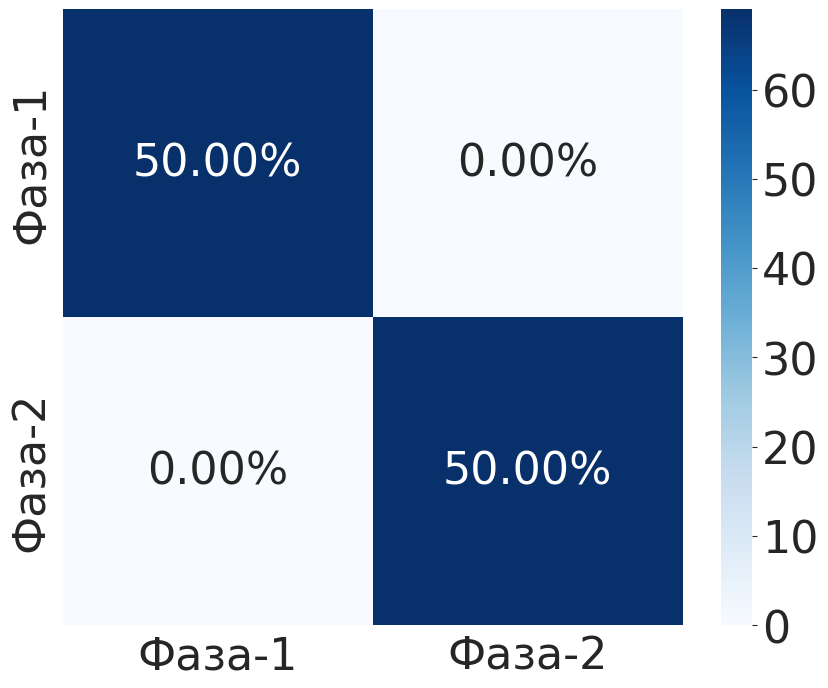

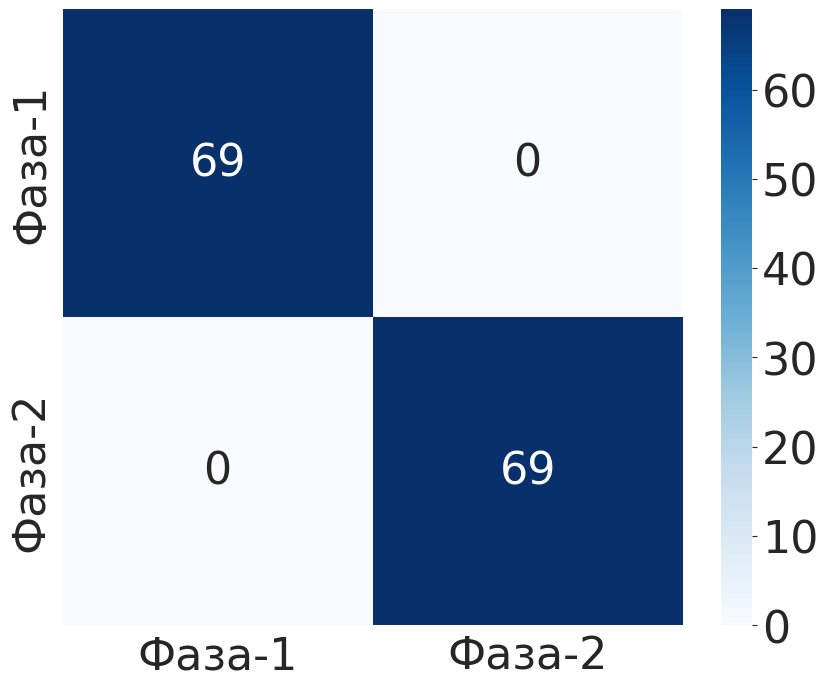

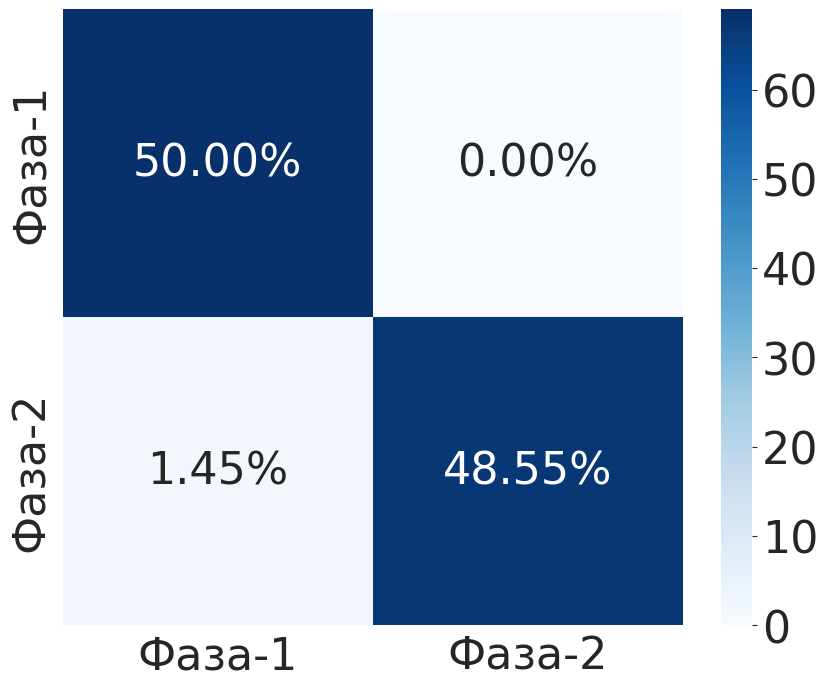

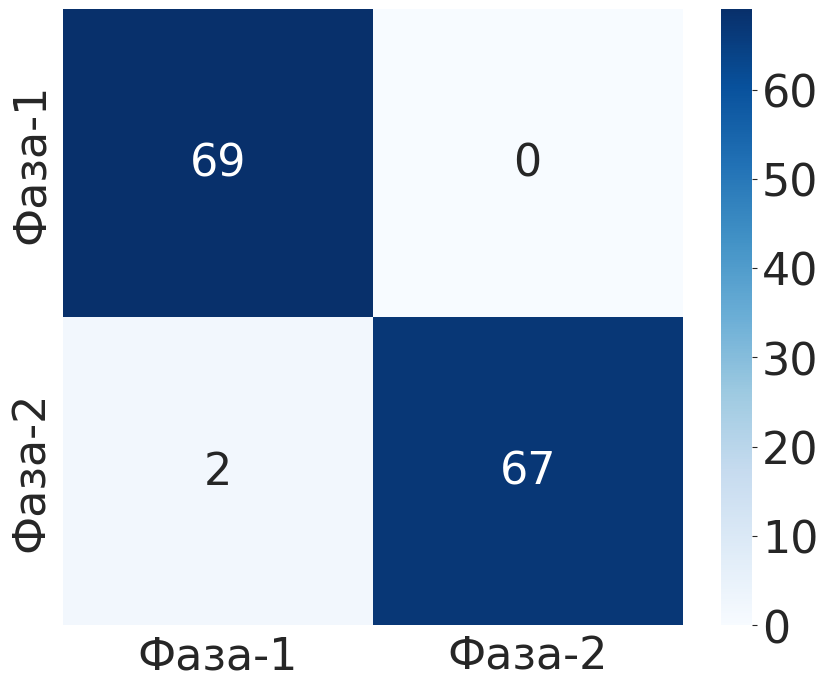

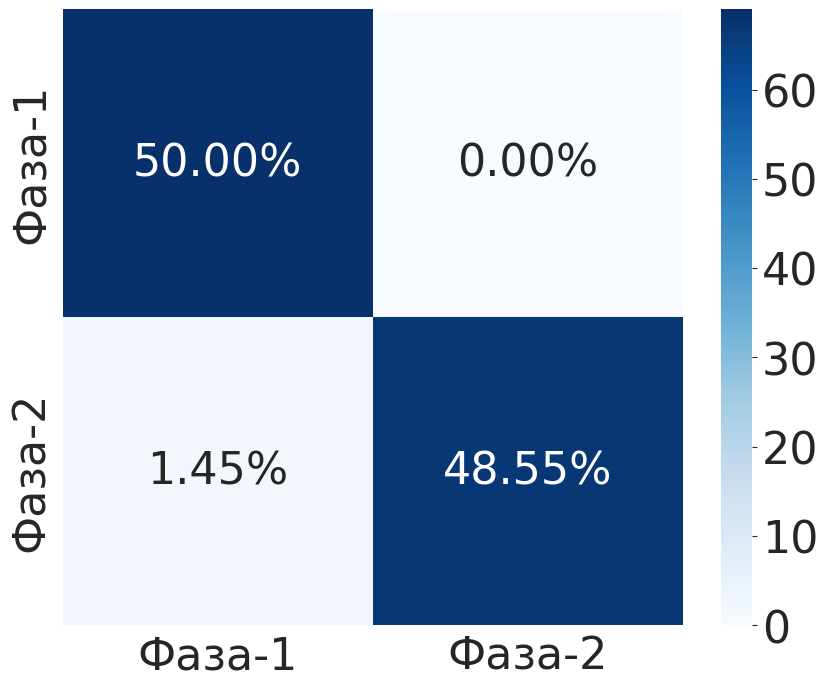

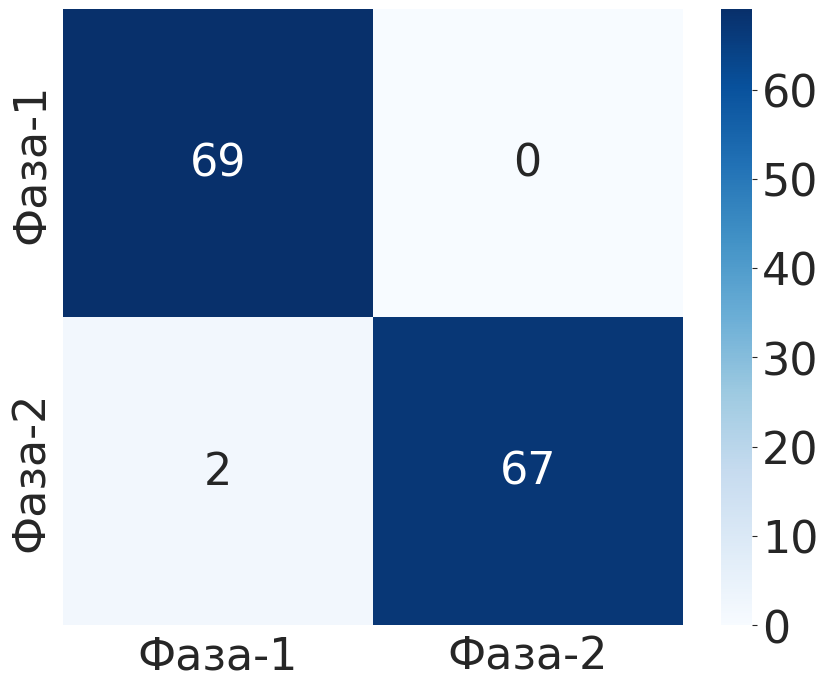

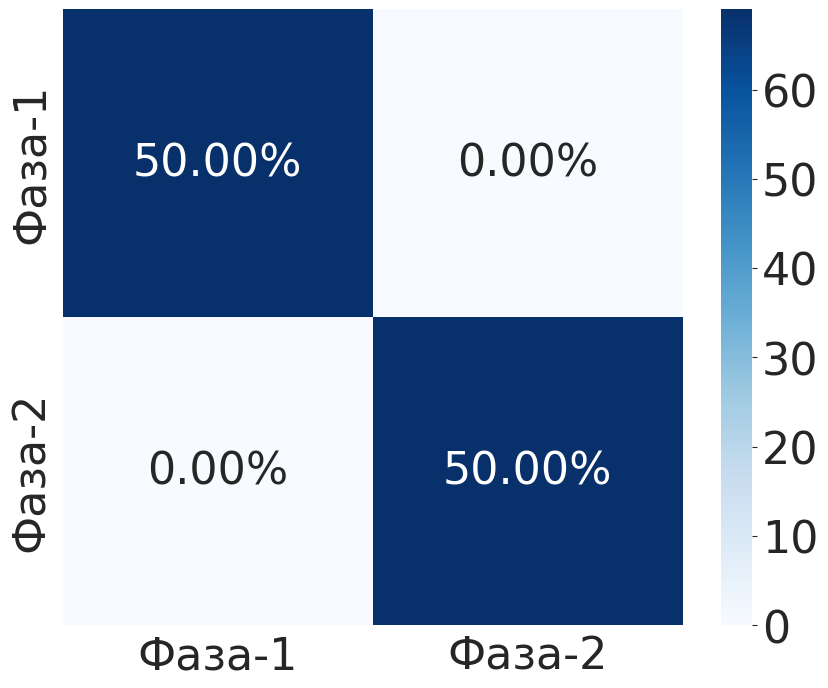

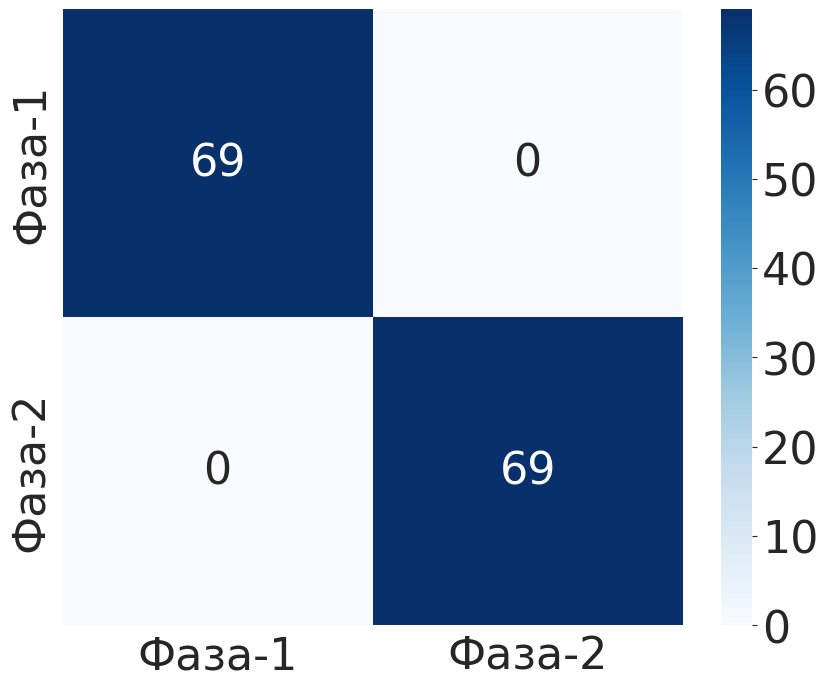

In [54]:

rfc_classifier = RandomForestClassifier()
cross_val_calssifier(X, y , rfc_classifier)


TRAIN: (140, 6) (140,)
TEST: (138, 6) (138,)
Accuracy: 1.0
Количество классов: 2

TRAIN: (278, 6) (278,)
TEST: (138, 6) (138,)
Accuracy: 0.9855072463768116
Количество классов: 2

TRAIN: (416, 6) (416,)
TEST: (138, 6) (138,)
Accuracy: 0.9855072463768116
Количество классов: 2

TRAIN: (554, 6) (554,)
TEST: (138, 6) (138,)
Accuracy: 1.0
Количество классов: 2


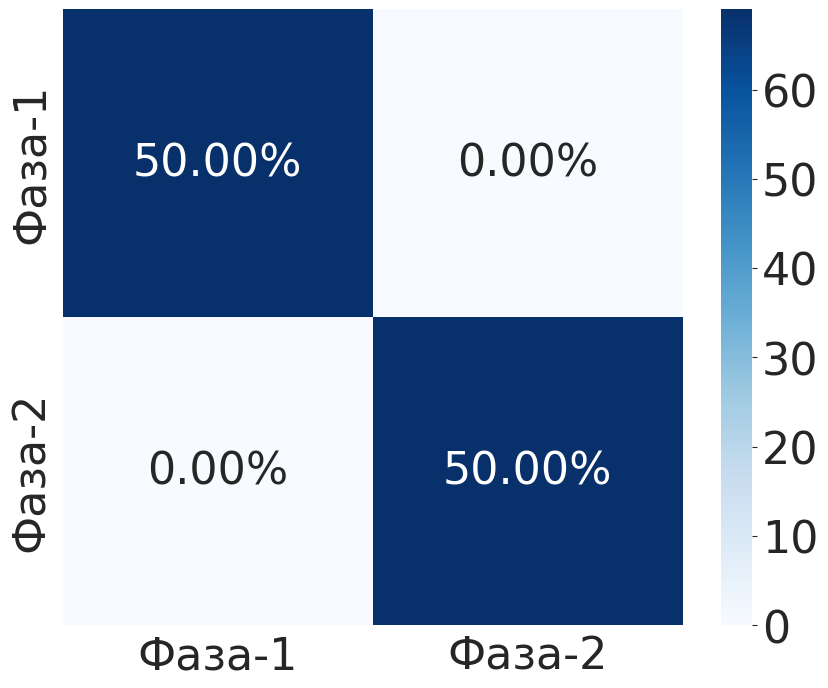

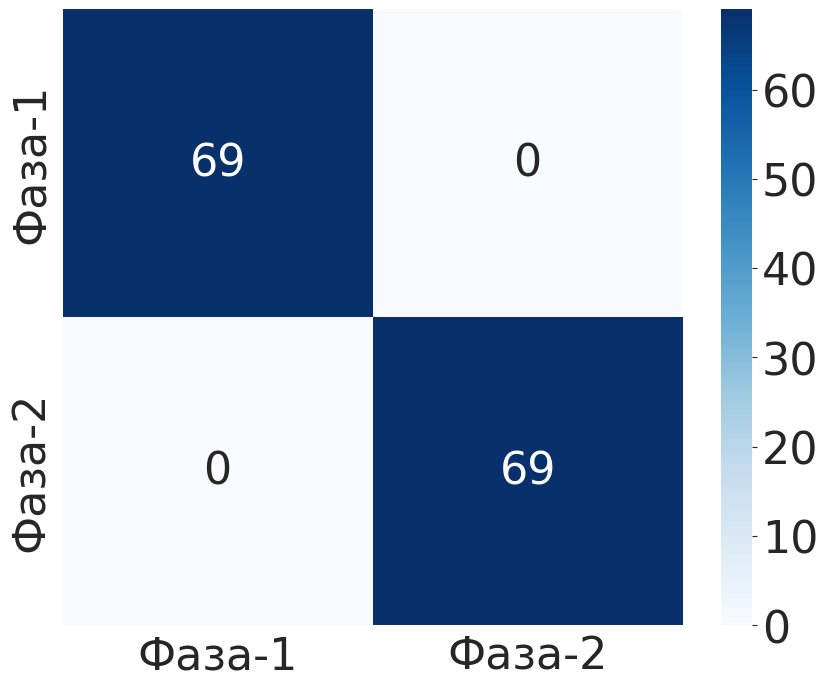

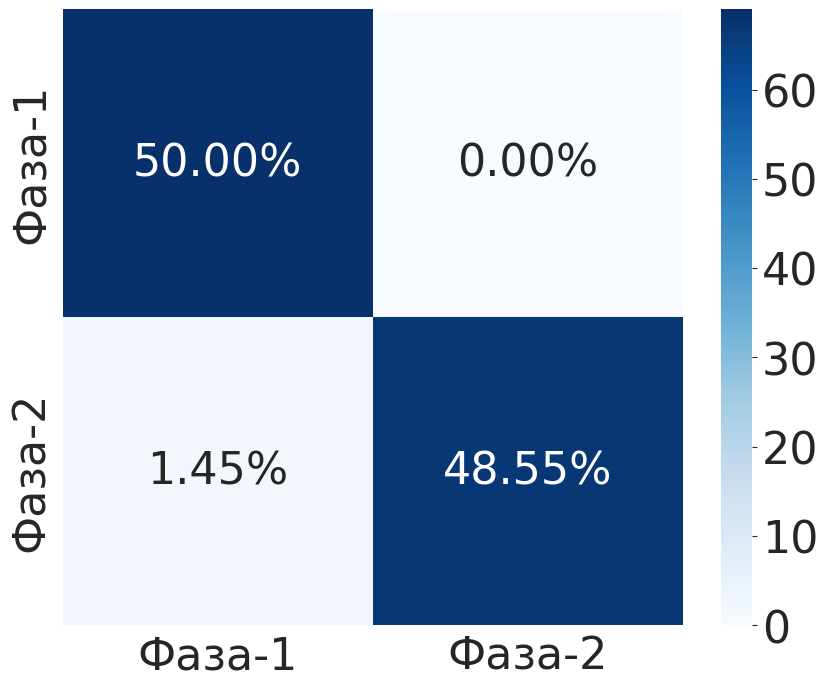

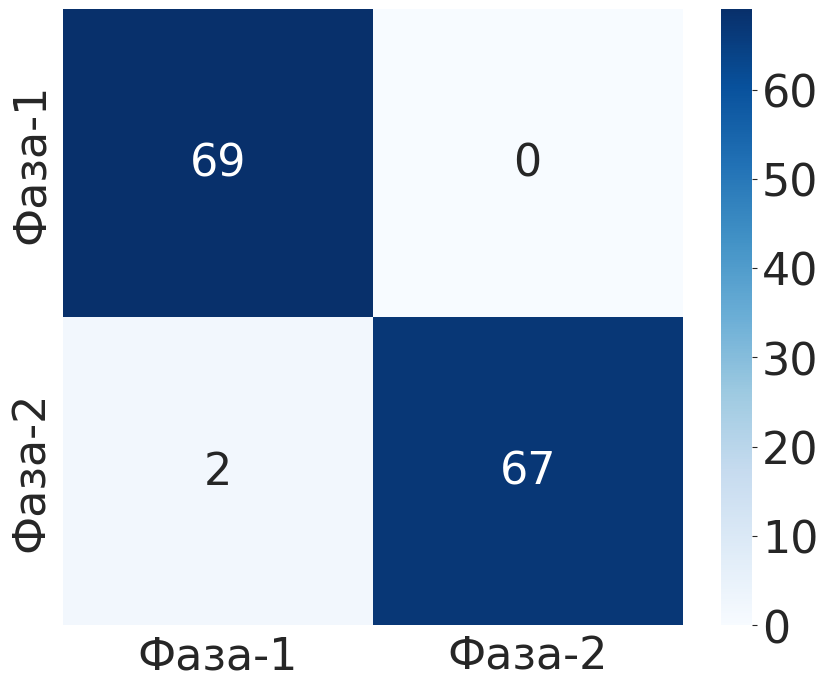

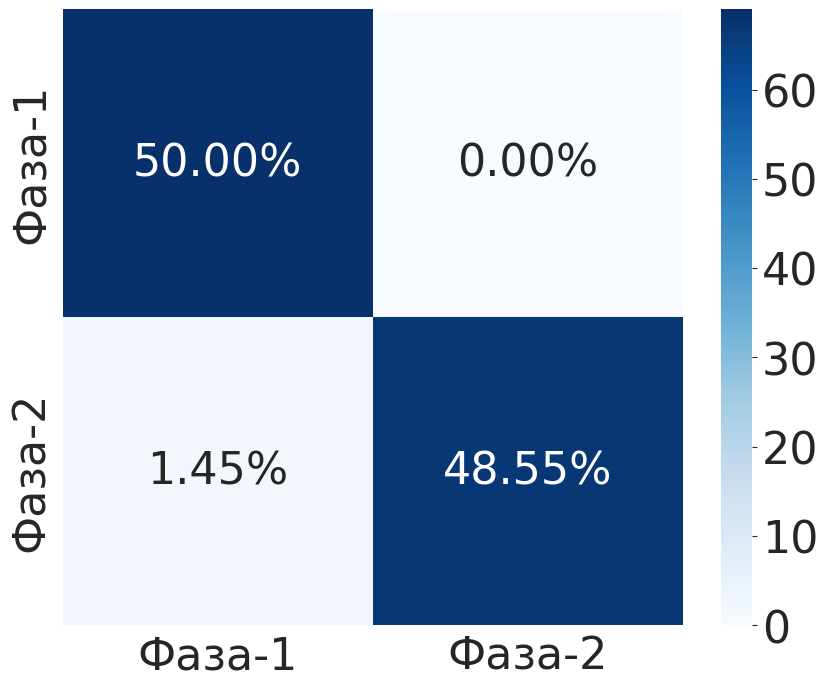

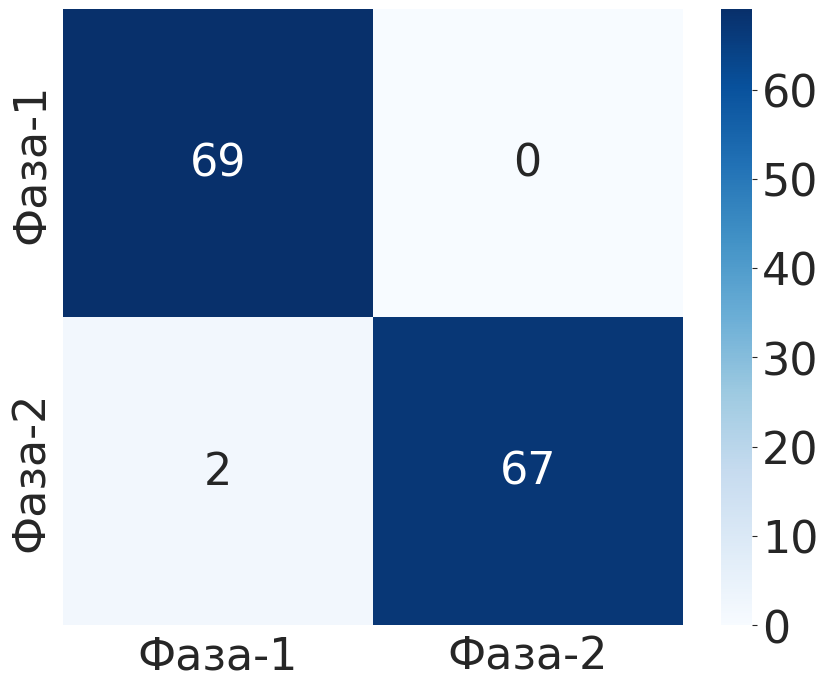

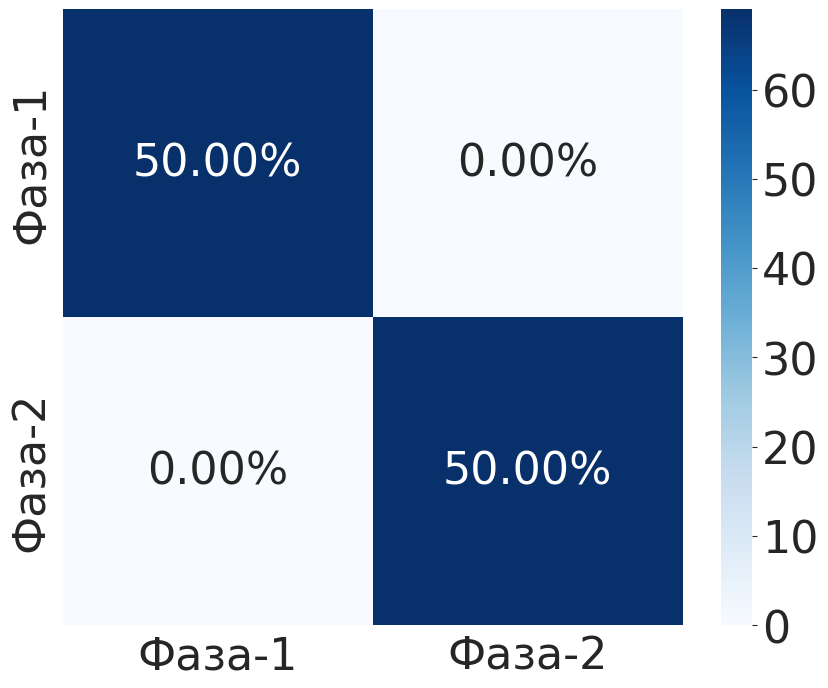

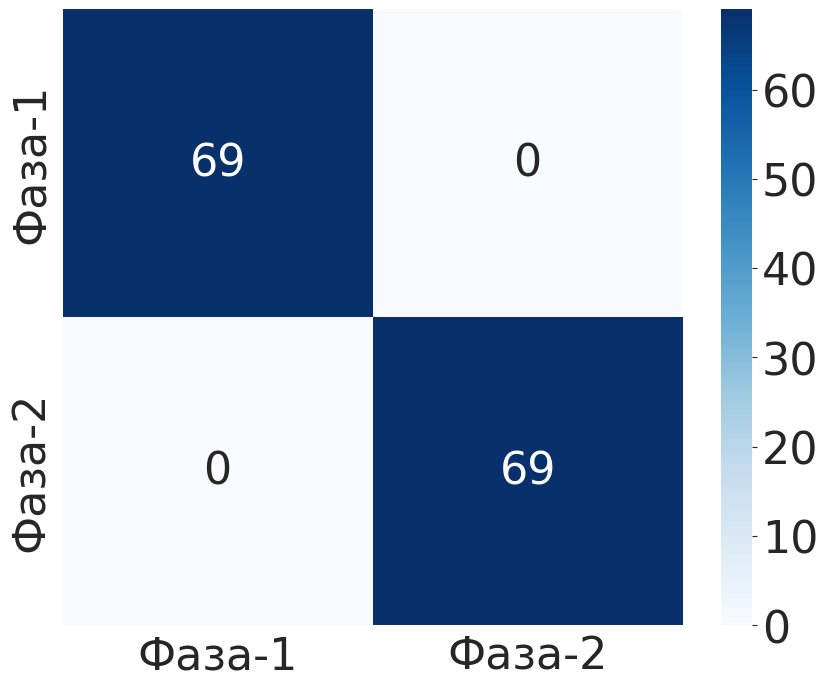

In [55]:
svc = SVC(C=0.9, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=100, n_jobs=4)
classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])

cross_val_calssifier(X, y , rfc_classifier)

In [56]:
plt.figure()
plt.plot(np.arange(4),ac_list, 'g.-')
plt.xlabel('Тестируемая выборка')
plt.ylabel('Точность предсказания')
plt.xticks(np.arange(4), ['1-ая четверть', '2-ая четверть', '3-ая четверть','4-ая четверть'])
plt.grid()

NameError: name 'ac_list' is not defined

<Figure size 640x480 with 0 Axes>

In [65]:
#making mannual adjisut,ents for other phases of cyclinng cycle
zeros=[0]*len(events_max)
marks=[3]*len(events_max)
threes=np.vstack([np.array(events_max)+1500,zeros,marks]).T


zeros=[0]*len(events_max)
marks=[4]*len(events_max)
fores=np.vstack([np.array(events_max)+2300,zeros,marks]).T


In [66]:

events=np.vstack([ones,twos, threes, fores])
events=events[events[:, 0].argsort()] #sorth the epochs matrix by timestamsp of events


In [67]:
#raw_data.plot(events,scalings={'eeg':0.3e0})

In [68]:
#check the sesond of events
print((ones[:,0]/raw_data.info['sfreq'])[:1])#приземление на пятку
print((twos[:,0]/raw_data.info['sfreq'])[:1])#отрыв пятки 
print((threes[:,0]/raw_data.info['sfreq'])[:1])#опопа на пятку 
print((fores[:,0]/raw_data.info['sfreq'])[:1])

[14.467]
[14.867]
[15.217]
[15.617]


In [69]:
#fps = vcap.get(cv2.CV_CAP_PROP_FPS)

video_path='../../../mp.mp4'

In [70]:
period

3800

6.803
6.806800000000014
7.203
7.207200000000015
7.553
7.57423333333335
7.953
7.974633333333351


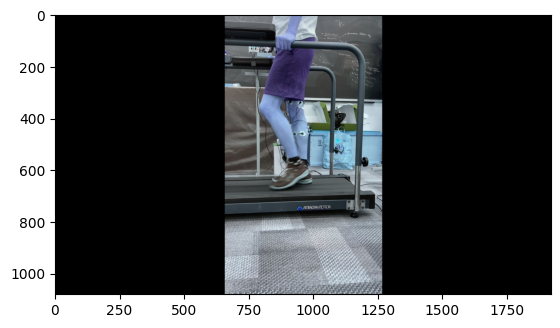

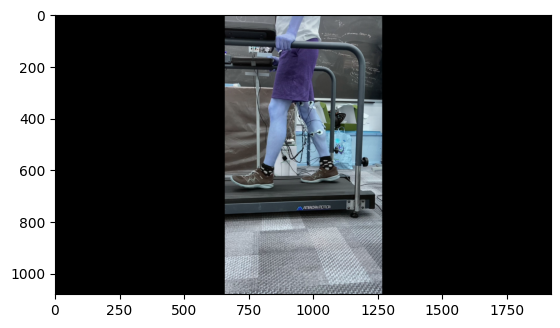

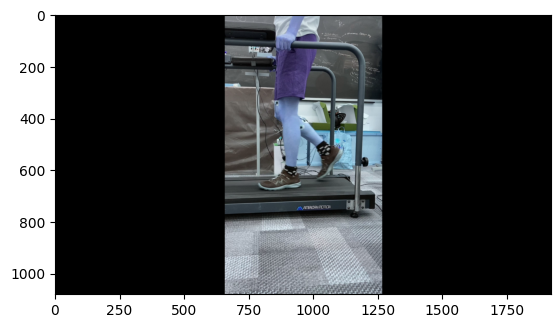

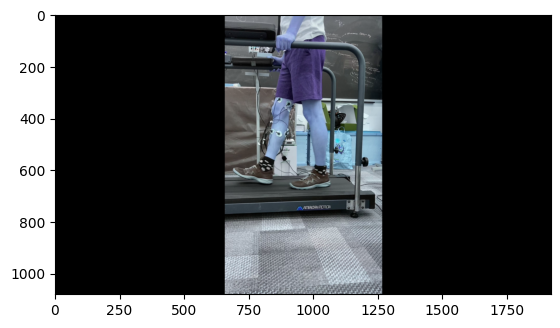

In [75]:
#watch over the video in those time stamps

ind=3

s=( (ones[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)

s=( (twos[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)


s=( (threes[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)

s=( (fores[ind,0]-raw_data.first_samp)/raw_data.info['sfreq'])
print(s)
get_frame(video_path,s)


In [113]:
epochs=mne.Epochs(raw_hil, events=events, tmin=-0.5, tmax=0.0, 
                        preload=True, 
                        baseline=None).apply_hilbert(envelope=True)

Not setting metadata
Not setting metadata
1384 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1384 events and 1001 original time points ...
1 bad epochs dropped


In [114]:

X, y = get_features_labels(epochs)

print('X: ', X.shape)
print('Y: ', y.shape)


Setting up band-pass filter from 2e+02 - 9e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 200.00
- Lower transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 175.00 Hz)
- Upper passband edge: 900.00 Hz
- Upper transition bandwidth: 100.00 Hz (-6 dB cutoff frequency: 950.00 Hz)
- Filter length: 133 samples (0.067 sec)

Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1321 samples (0.660 sec)



/var/folders/2m/6g8qzjcd00n9j42dqh2ndj780000gn/T/ipykernel_16942/1321716249.py:2: RuntimeWarning: filter_length (1321) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(200, 900).apply_hilbert(envelope=True).filter(0, 20)


X:  (1383, 12012)
Y:  (1383,)


In [115]:
categs=['Фаза-1','Фаза-2', 'Фаза-3', 'Фаза-4']


TRAIN: (279, 6) (279,)
TEST: (276, 6) (276,)
Accuracy: 0.9927536231884058
Количество классов: 4

TRAIN: (555, 6) (555,)
TEST: (276, 6) (276,)
Accuracy: 0.9528985507246377
Количество классов: 4

TRAIN: (831, 6) (831,)
TEST: (276, 6) (276,)
Accuracy: 1.0
Количество классов: 4

TRAIN: (1107, 6) (1107,)
TEST: (276, 6) (276,)
Accuracy: 0.9891304347826086
Количество классов: 4


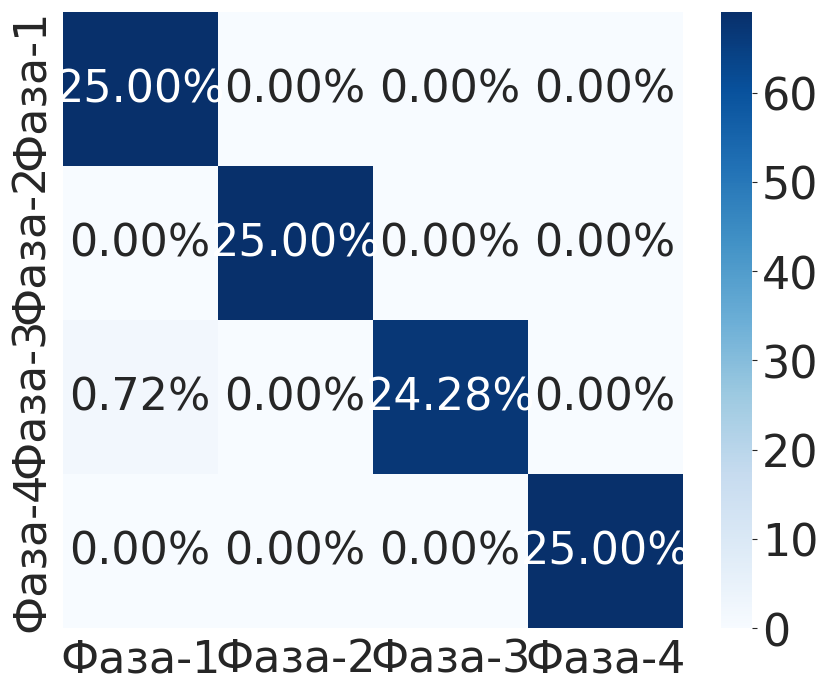

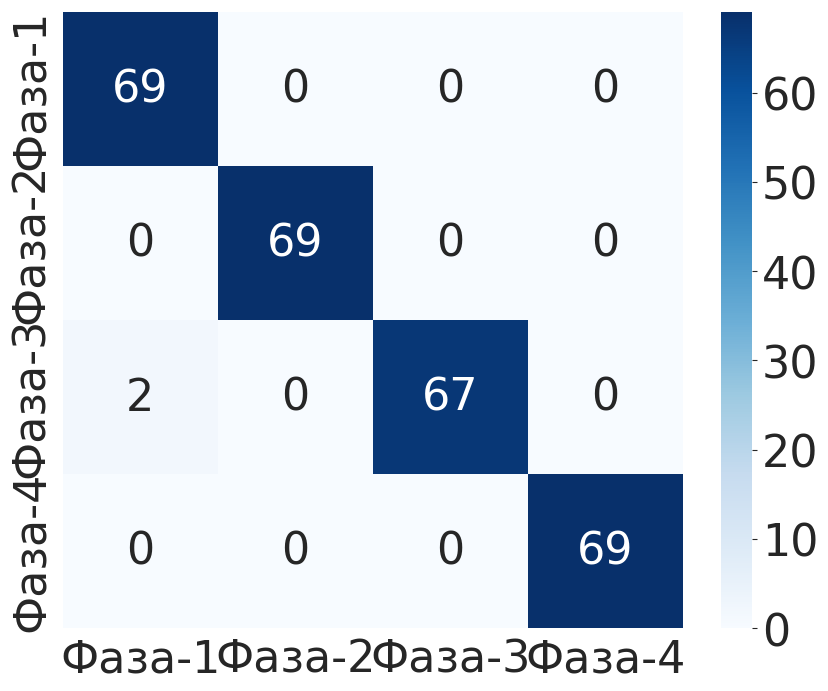

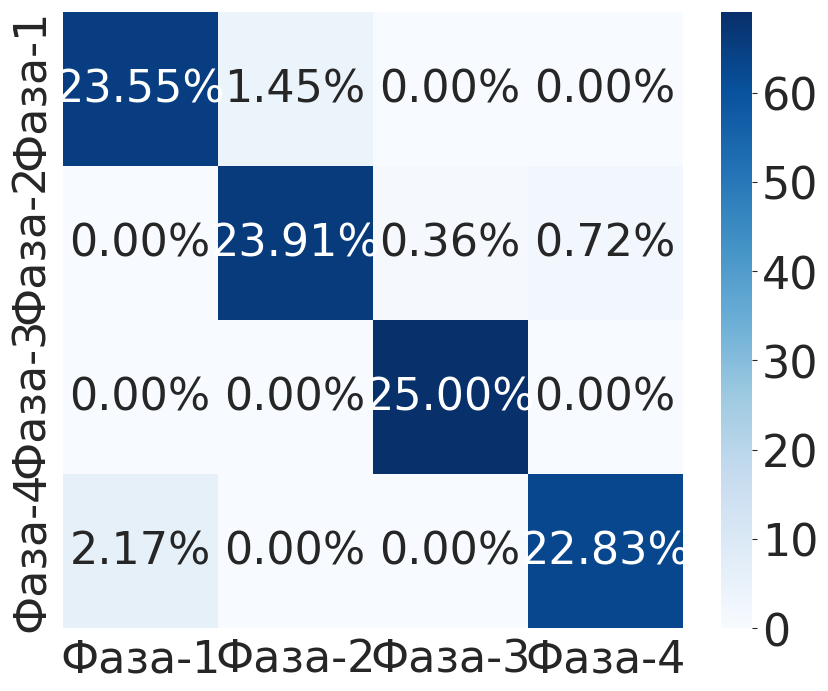

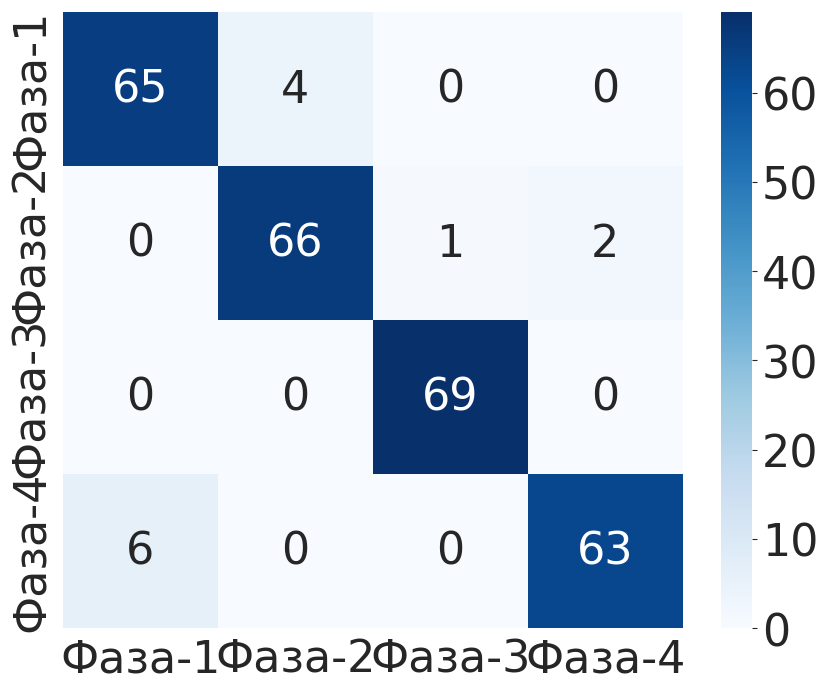

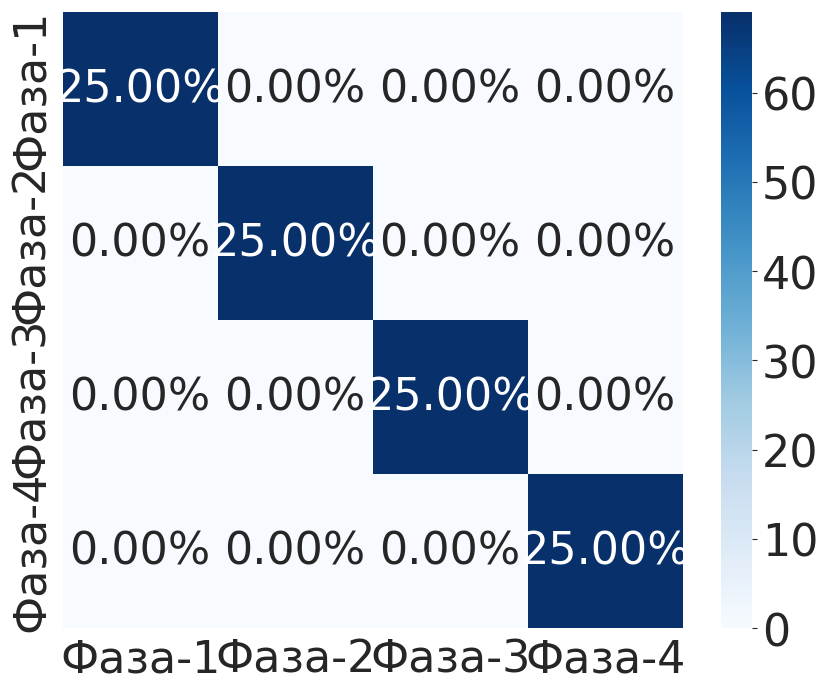

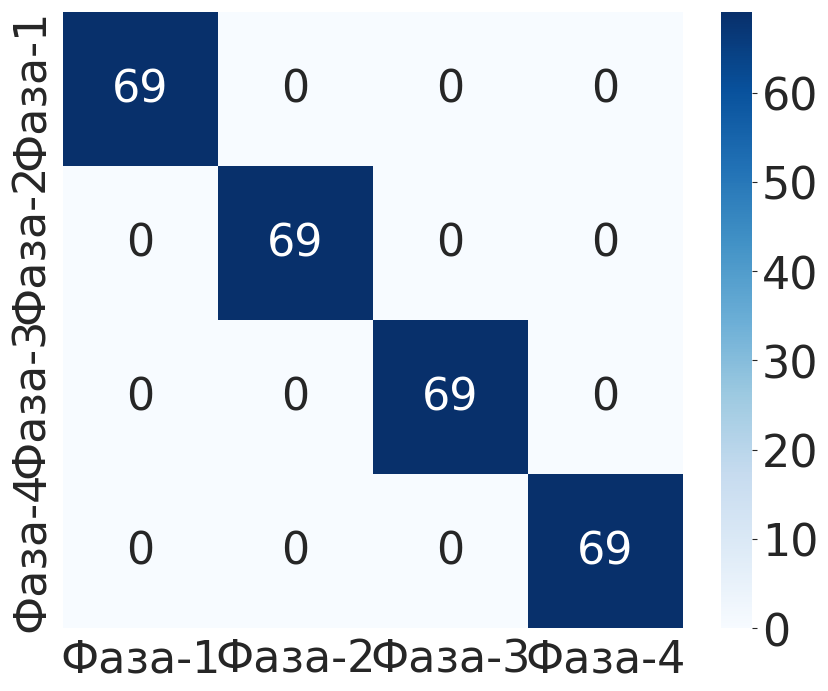

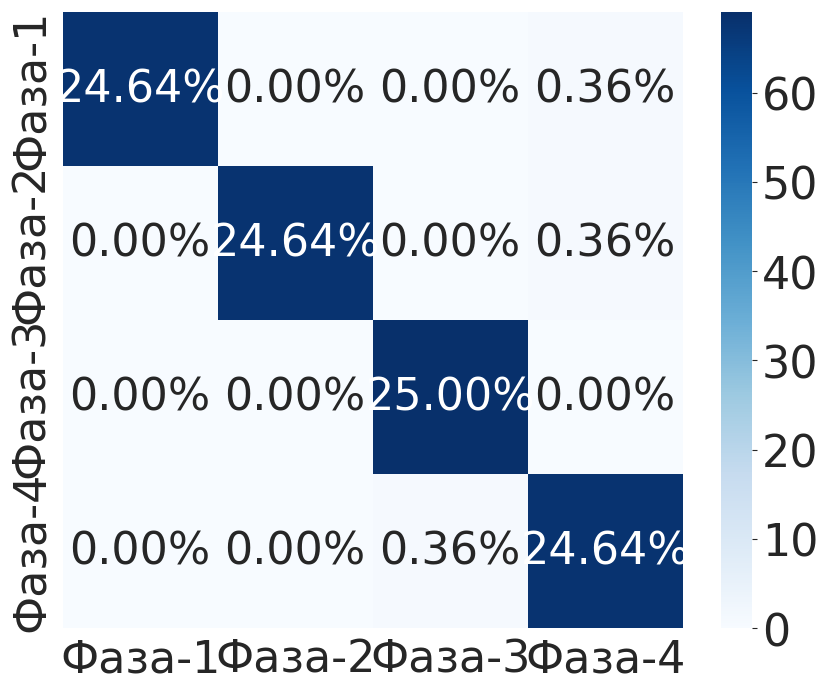

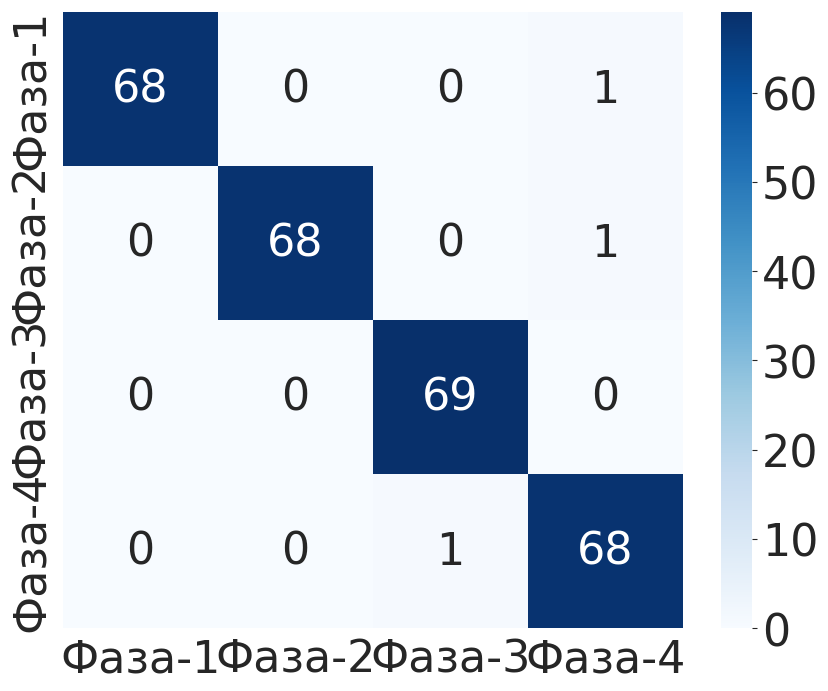

In [116]:
classifier = SVC(C=0.8, kernel='rbf', probability=True)
cross_val_calssifier(X, y , classifier,categs)



TRAIN: (279, 6) (279,)
TEST: (276, 6) (276,)
Accuracy: 0.9818840579710145
Количество классов: 4

TRAIN: (555, 6) (555,)
TEST: (276, 6) (276,)
Accuracy: 0.9456521739130435
Количество классов: 4

TRAIN: (831, 6) (831,)
TEST: (276, 6) (276,)
Accuracy: 0.9927536231884058
Количество классов: 4

TRAIN: (1107, 6) (1107,)
TEST: (276, 6) (276,)
Accuracy: 1.0
Количество классов: 4


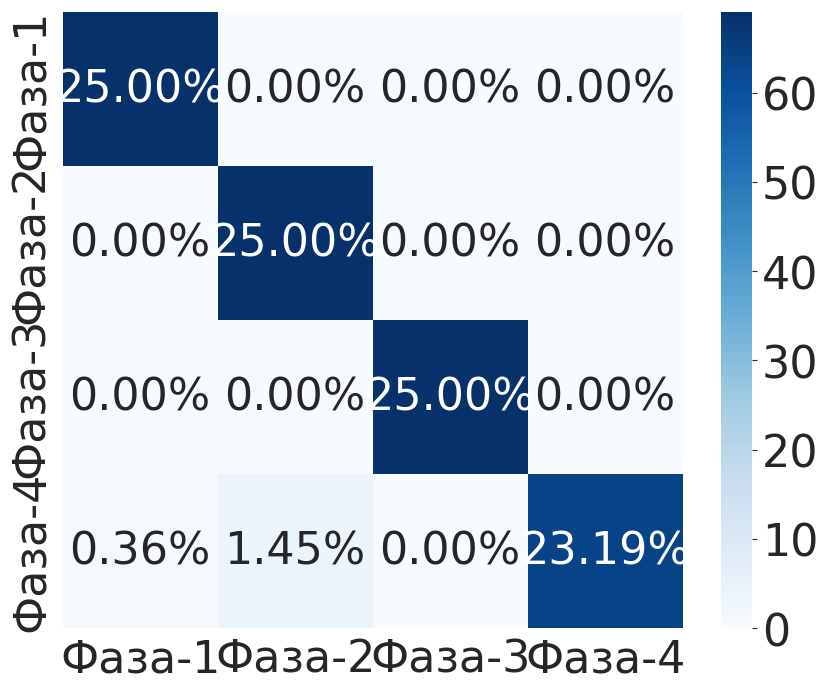

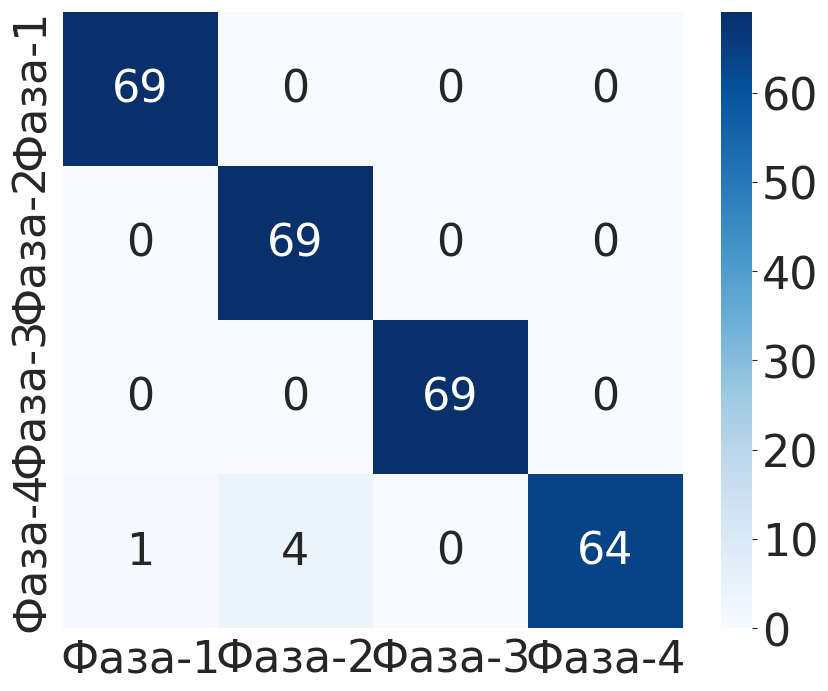

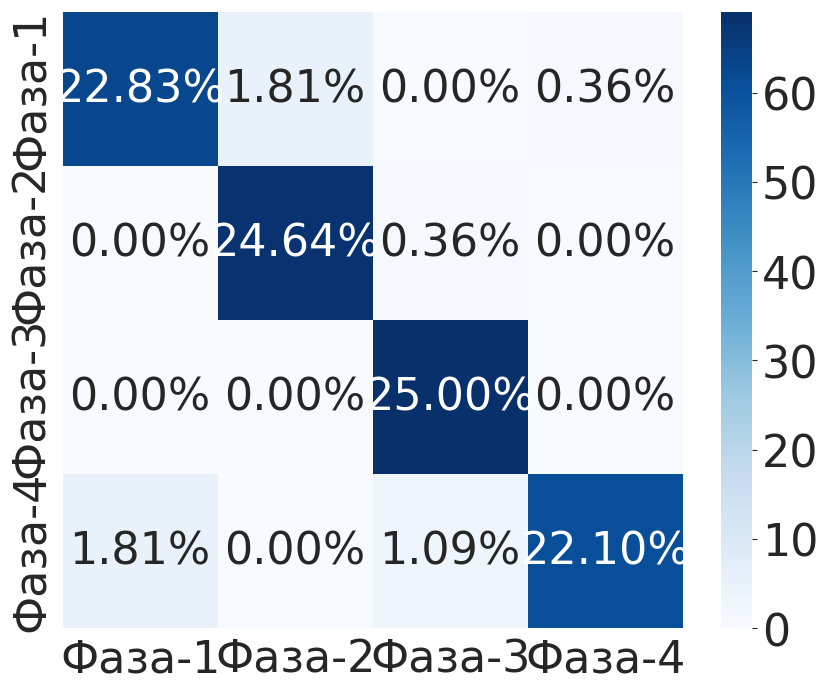

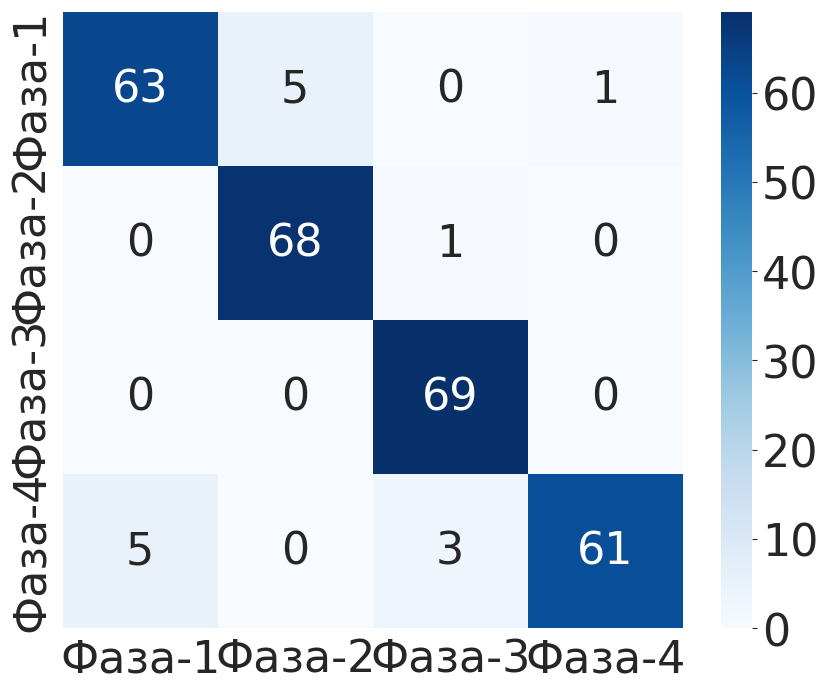

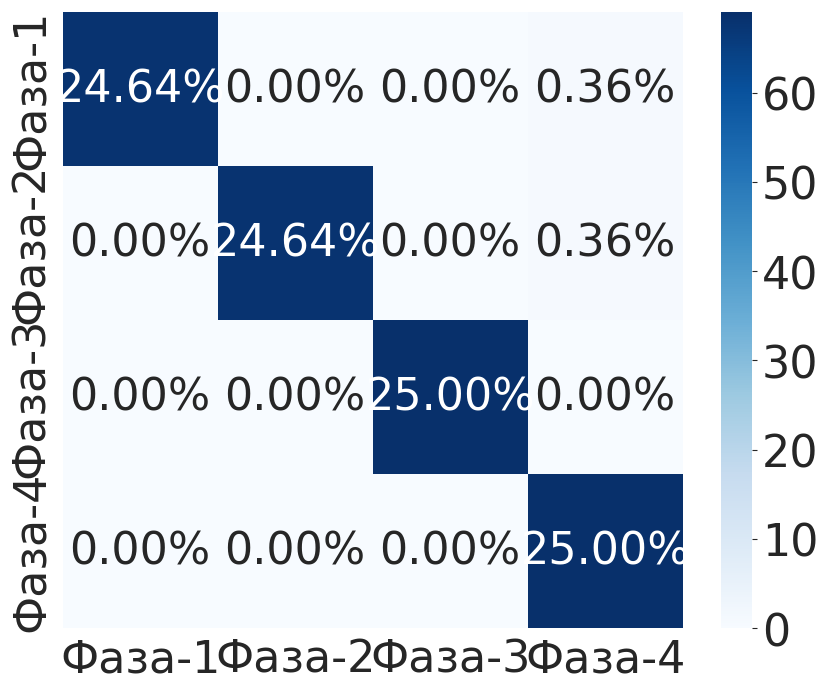

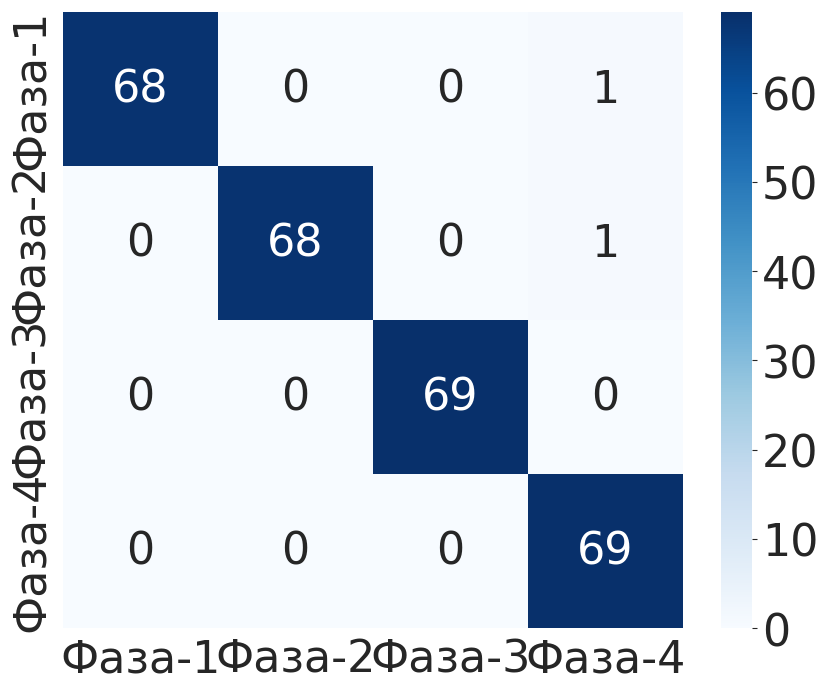

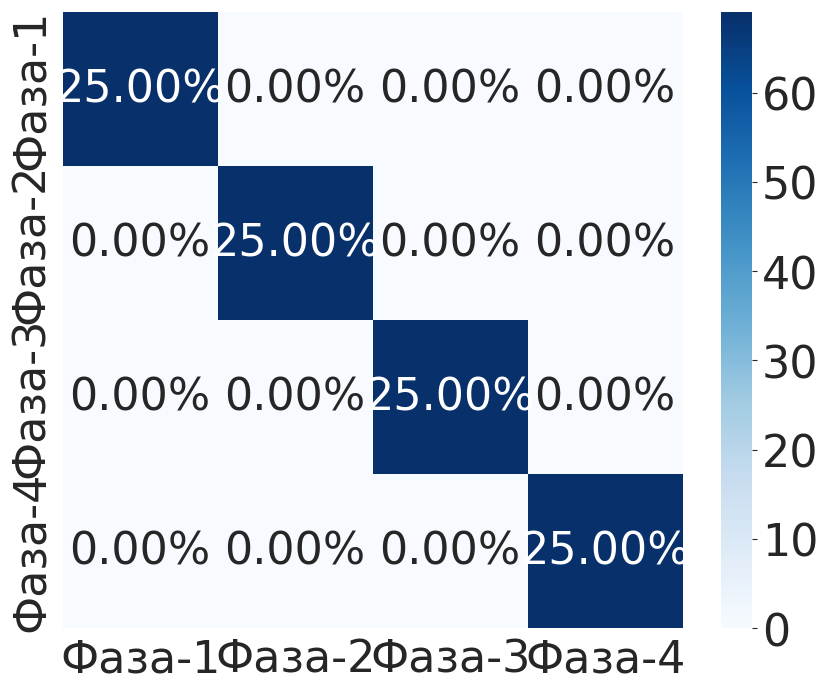

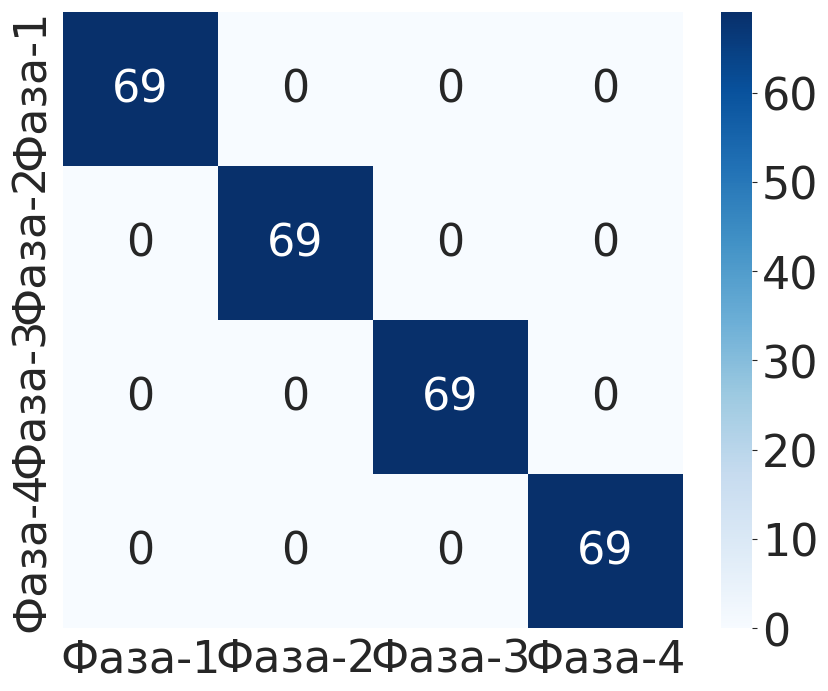

In [117]:

rfc_classifier = RandomForestClassifier()
cross_val_calssifier(X, y , rfc_classifier,categs)


TRAIN: (279, 6) (279,)
TEST: (276, 6) (276,)
Accuracy: 0.9818840579710145
Количество классов: 4

TRAIN: (555, 6) (555,)
TEST: (276, 6) (276,)
Accuracy: 0.9420289855072463
Количество классов: 4

TRAIN: (831, 6) (831,)
TEST: (276, 6) (276,)
Accuracy: 0.9927536231884058
Количество классов: 4

TRAIN: (1107, 6) (1107,)
TEST: (276, 6) (276,)
Accuracy: 0.9927536231884058
Количество классов: 4


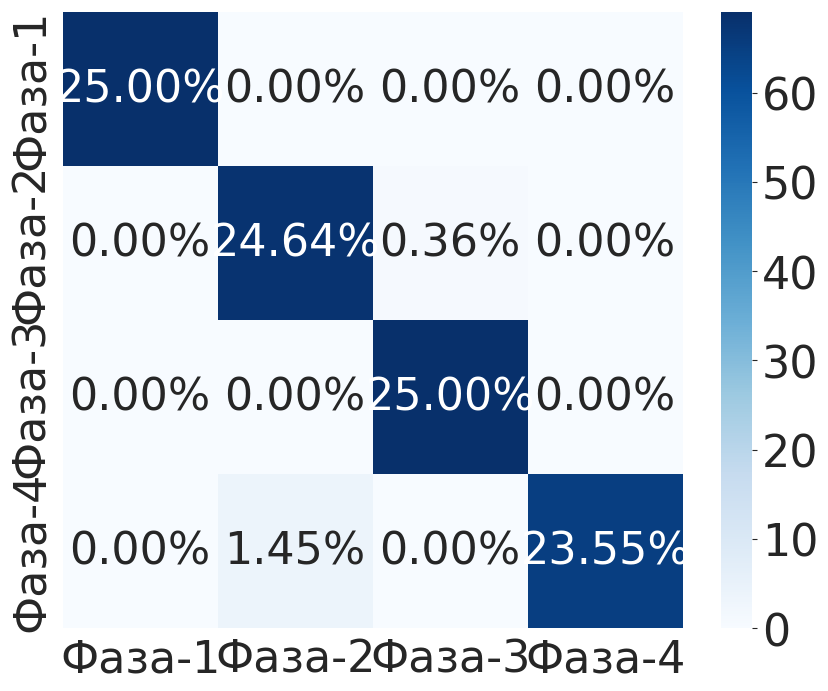

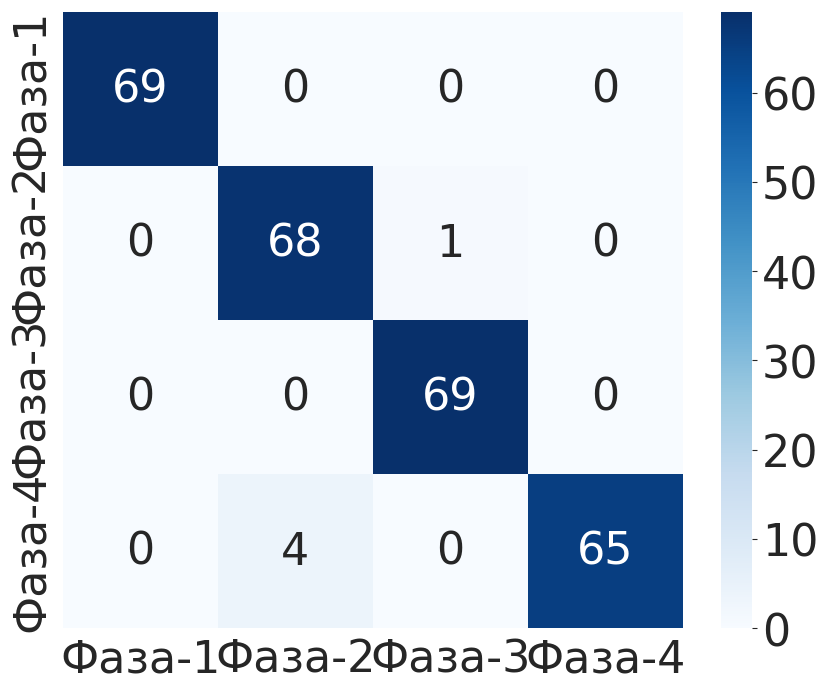

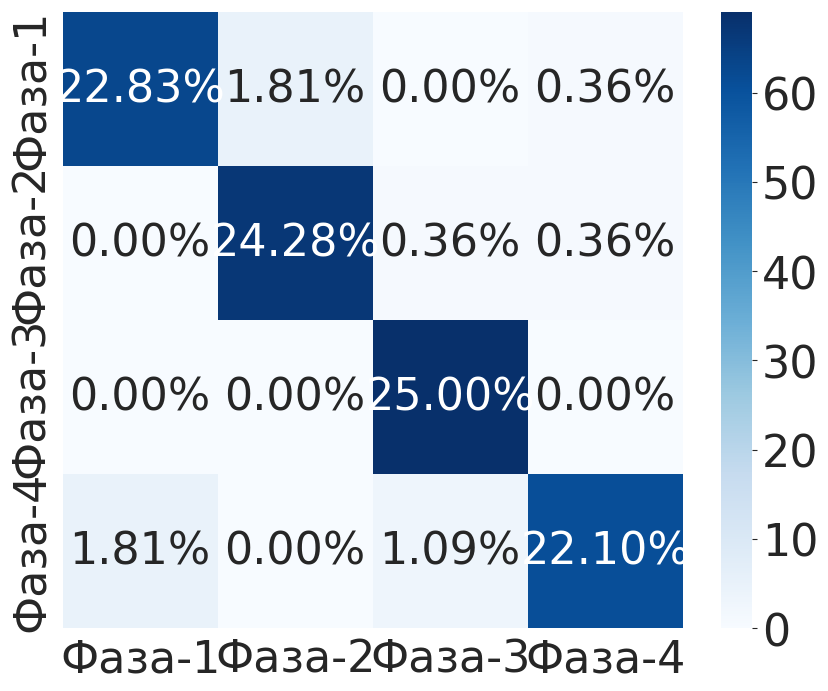

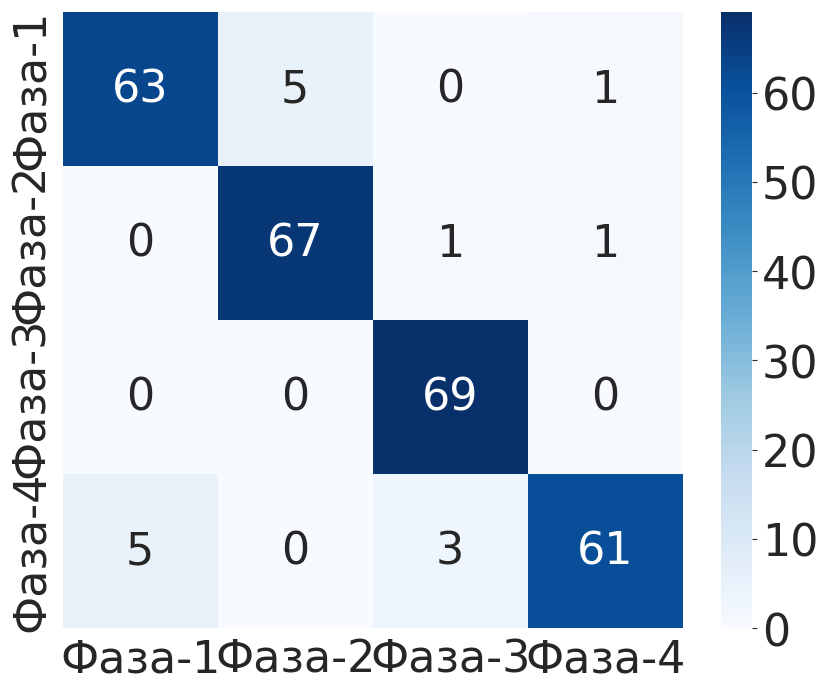

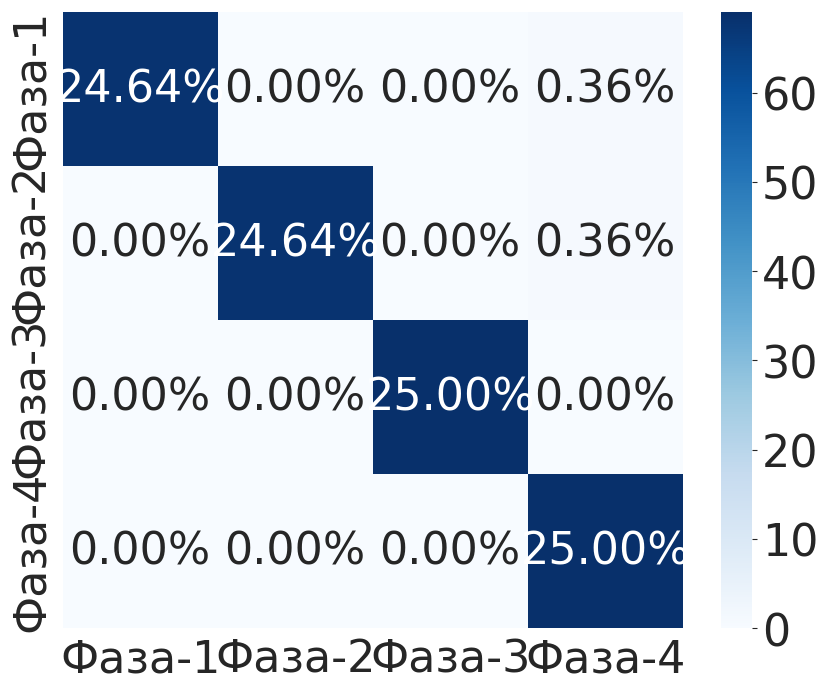

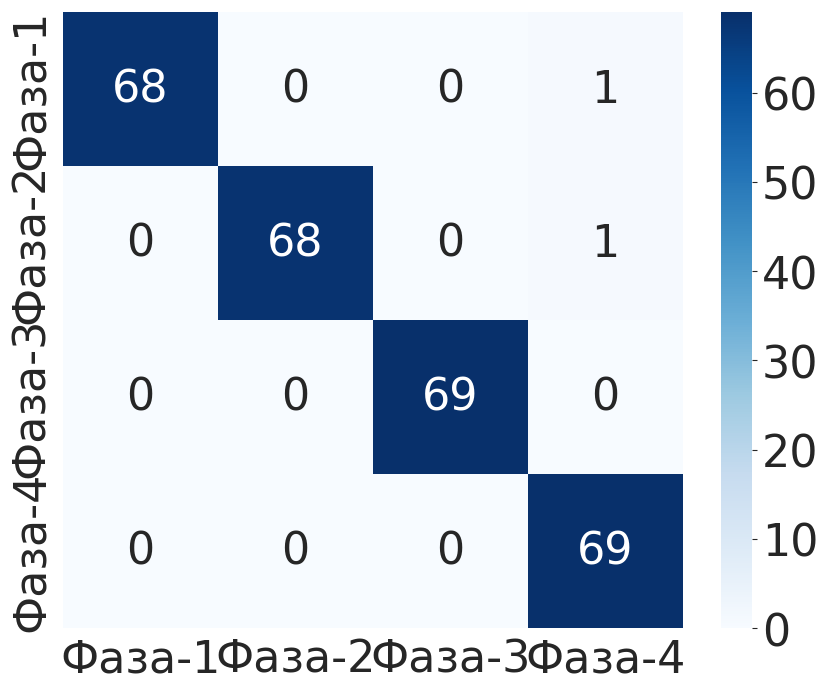

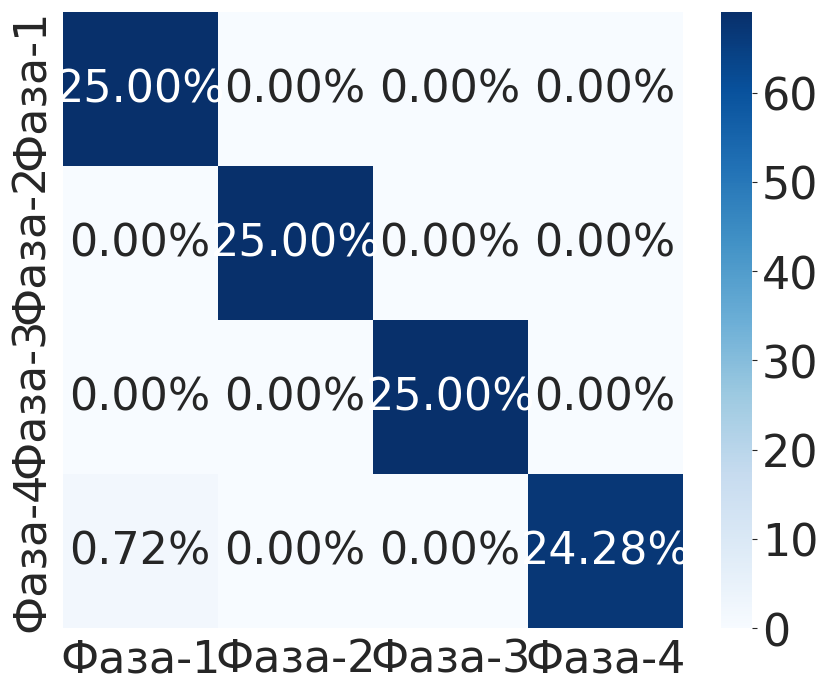

In [ ]:
svc = SVC(C=0.9, kernel='rbf', probability=True)
lr = LogisticRegression(max_iter=100, n_jobs=4)
classifier=StackingClassifier([('SVC', svc), ('Logistic regression', lr)])

cross_val_calssifier(X, y , rfc_classifier, categs)